In [1]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

In [6]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import torchvision.models as models
from functools import partial
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
    ParametersRecord,
    array_from_numpy
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on mps
Flower 1.15.1 / PyTorch 2.6.0


In [7]:

BATCH_SIZE = 32

def load_datasets(partition_id, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [8]:

def create_mobilenetv2(width_multiplier=0.5, num_classes=10):
    # Create a class that inherits from nn.Module
    class MobileNetV2CIFAR10(nn.Module):
        def __init__(self):
            super(MobileNetV2CIFAR10, self).__init__()
            
            # Load the base MobileNetV2 model with custom width_multiplier
            self.model = models.mobilenet_v2(pretrained=False, width_mult=width_multiplier)
            
            # Modify the first conv layer for 32x32 CIFAR-10 images
            first_conv_layer = self.model.features[0][0]
            self.model.features[0][0] = nn.Conv2d(
                3,
                int(32 * width_multiplier),
                kernel_size=3,
                stride=1,  # Changed from 2 to 1 for CIFAR-10
                padding=1,
                bias=False
            )
            
            # Modify the classifier for the desired number of classes
            last_channel = int(1280 * width_multiplier) if width_multiplier > 1.0 else 1280
            self.model.classifier[1] = nn.Linear(last_channel, num_classes)
        
        def forward(self, x):
            return self.model(x)
            
    return MobileNetV2CIFAR10

Net = create_mobilenetv2(width_multiplier=0.5)

In [ ]:
# class Net(nn.Module):
#     def __init__(self) -> None:
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# class Net(nn.Module):
#     def __init__(self) -> None:
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
#         self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
#         self.pool3 = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(256*4*4, 1024)
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 10)
        
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.pool1(x)
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.pool2(x)
#         x = F.relu(self.conv5(x))
#         x = F.relu(self.conv6(x))
#         x = self.pool3(x)
#         x = x.view(-1, 256*4*4)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

class MoonNet(nn.Module):
    """Returns both the representation (penultimate layer output) and classification"""
    def __init__(self) -> None:
        super(MoonNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        representation = x.clone()
        classification = self.fc3(x)
        return representation, classification

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


# def set_parameters(net, parameters, trainable_layers=-1):
#     """Set model parameters from a list of NumPy arrays."""
#     current_state = OrderedDict(net.state_dict())

#     # DEBUG 
#     print(f"=== SET PARAMS === \nParam keys: {current_state.keys()}")
    
#     if trainable_layers == -1:
#         # Update all parameters
#         params_dict = zip(current_state.keys(), parameters)
#         state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
#         net.load_state_dict(state_dict, strict=True)
#     else:
#         # Only update the specified layer's parameters
#         # Convert current state to numpy arrays
#         numpy_state = [param.cpu().numpy() for param in current_state.values()]
        
#         # Update the specific indices with new parameters
#         numpy_state[trainable_layers*2] = parameters[0]
#         numpy_state[trainable_layers*2 + 1] = parameters[1]
        
#         # Convert back to torch and update state dict
#         for idx, key in enumerate(current_state.keys()):
#             current_state[key] = torch.from_numpy(numpy_state[idx])
        
#         net.load_state_dict(current_state, strict=True)
def set_parameters(net, parameters, trainable_layers=-1):
    """Set model parameters from a list of NumPy arrays."""
    current_state = OrderedDict(net.state_dict())
    # DEBUG 
    print(f"=== SET PARAMS === \nParam keys: {current_state.keys()}")
    
    if trainable_layers == -1:
        # Update all parameters
        # Make sure parameters and current_state.keys() have the same length
        if len(parameters) != len(current_state):
            print(f"Warning: Number of parameters ({len(parameters)}) doesn't match state dict keys ({len(current_state)})")
            
        # Create a proper mapping between keys and parameters
        state_dict = OrderedDict()
        for i, (key, param) in enumerate(zip(current_state.keys(), parameters)):
            # Handle batch norm parameters properly
            if 'running_mean' in key or 'running_var' in key or 'num_batches_tracked' in key:
                # Keep the existing values for running stats
                state_dict[key] = current_state[key]
            else:
                # Only update if the parameter is not empty
                if isinstance(param, np.ndarray) and param.size > 0:
                    state_dict[key] = torch.Tensor(param)
                else:
                    # Keep the existing parameter if the new one is empty
                    state_dict[key] = current_state[key]
                    print(f"Warning: Empty parameter for {key}, keeping original")
        
        # Make sure all keys from current state are in the new state_dict
        for key in current_state:
            if key not in state_dict:
                state_dict[key] = current_state[key]
                
        net.load_state_dict(state_dict, strict=True)
    else:
        # Get the keys that correspond to the trainable layer
        keys = list(current_state.keys())
        if trainable_layers*2 < len(keys) and trainable_layers*2 + 1 < len(keys):
            weight_key = keys[trainable_layers*2]
            bias_key = keys[trainable_layers*2 + 1]
            
            # Only update if the parameter shapes match
            if (current_state[weight_key].shape == parameters[0].shape and 
                current_state[bias_key].shape == parameters[1].shape):
                # Convert to torch tensors
                current_state[weight_key] = torch.from_numpy(parameters[0])
                current_state[bias_key] = torch.from_numpy(parameters[1])
                net.load_state_dict(current_state, strict=True)
            else:
                print(f"Shape mismatch: {weight_key} expected {current_state[weight_key].shape}, got {parameters[0].shape}")
                print(f"Shape mismatch: {bias_key} expected {current_state[bias_key].shape}, got {parameters[1].shape}")
        else:
            print(f"Layer index out of range. Max index is {len(keys)//2 - 1}")

# def set_parameters(net, parameters: List[np.ndarray]):
#     params_dict = zip(net.state_dict().keys(), parameters)
#     state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
#     net.load_state_dict(state_dict, strict=True)

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),betas=(0.999,0.999))
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    print(f"Started training moon")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    global_net.eval()

    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for batch in train_loader:
            x, target = batch["img"], batch["label"]
            x, target = x.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            # pro3 is the representation by the previous model (Line 16 of Algorithm 1)
            with torch.no_grad():
                pro2, _ = global_net(x)
                pro3, _ = previous_net(x)

            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to("cpu")
            logits /= temperature
            labels = torch.zeros(x.size(0)).to(DEVICE).long()

            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)

            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)

            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )


def test_moon(net, testloader):
    """
    Evaluate the network on the entire test set.
    Same as the regular test, but using the MoonNet 
    (where the output is a tuple of (representation, classification) )
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            _, outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy




def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
#         """Freeze specified layers of the model."""
#         for idx, (name, param) in enumerate(model.named_parameters()):
#             if idx == trainable_layers or trainable_layers == -1:
#                 param.requires_grad = True
#             else:
#                 param.requires_grad = False



def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        trainable_layers_set = []
        if trainable_layers == -1:
            trainable_layers_set = [-1]
        else:
            trainable_layers_set = [trainable_layers *2, trainable_layers *2 +1]

        for idx, (name, param) in enumerate(model.named_parameters()):
            
            if idx in trainable_layers_set or trainable_layers_set[0] == -1:
                param.requires_grad = True
                print(f"layer index is {idx} and name{name} is trainabe")
            else:
                param.requires_grad = False
                print(f"layer index is {idx} and name{name} is frozen")




In [16]:

NETWORK_LEN = len(Net().state_dict().keys()) //2 
EPOCHS = 8
NUM_PARTITIONS = 6
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 2
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 316


/opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
from flwr.common import NDArrays, Scalar
import sys
def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate


def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size


# Normal FedAvg

In [18]:
from typing import Union


from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters) *2
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [19]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [ ]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=316, no round_timeout
INFO :      
INFO :      [INIT]
/opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.0720742369890213, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppA

(ClientAppActor pid=2240) [Client 3] fit, config: {}
(ClientAppActor pid=2240) === SET PARAMS === 
(ClientAppActor pid=2240) Param keys: odict_keys(['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.0.1.num_batches_tracked', 'model.features.1.conv.0.0.weight', 'model.features.1.conv.0.1.weight', 'model.features.1.conv.0.1.bias', 'model.features.1.conv.0.1.running_mean', 'model.features.1.conv.0.1.running_var', 'model.features.1.conv.0.1.num_batches_tracked', 'model.features.1.conv.1.weight', 'model.features.1.conv.2.weight', 'model.features.1.conv.2.bias', 'model.features.1.conv.2.running_mean', 'model.features.1.conv.2.running_var', 'model.features.1.conv.2.num_batches_tracked', 'model.features.2.conv.0.0.weight', 'model.features.2.conv.0.1.weight', 'model.features.2.conv.0.1.bias', 'model.features.2.conv.0.1.running_mean', 'model.features.2.conv.0.1.running_var', 'm

(raylet) [2025-03-13 12:05:29,298 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 24505479168; capacity: 494384795648. Object creation will fail if spilling is required.
(ClientAppActor pid=2239) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 5x across cluster]
(ClientAppActor pid=2239)   warnings.warn( [repeated 5x across cluster]
(ClientAppActor pid=2239) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`. [repeated 5x across cluster]
(ClientAppActor pid=2239)   warnings.

(ClientAppActor pid=2241) Epoch 1: train loss 0.07388477027416229, accuracy 0.14536453645364536
(ClientAppActor pid=2242) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2242) === SET PARAMS ===  [repeated 5x across cluster]
(ClientAppActor pid=2242) Param keys: odict_keys(['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.0.1.num_batches_tracked', 'model.features.1.conv.0.0.weight', 'model.features.1.conv.0.1.weight', 'model.features.1.conv.0.1.bias', 'model.features.1.conv.0.1.running_mean', 'model.features.1.conv.0.1.running_var', 'model.features.1.conv.0.1.num_batches_tracked', 'model.features.1.conv.1.weight', 'model.features.1.conv.2.weight', 'model.features.1.conv.2.bias', 'model.features.1.conv.2.running_mean', 'model.features.1.conv.2.running_var', 'model.features.1.conv.2.num_batches_tracked', 'model.features.2.conv.0.0.weight', '

(raylet) [2025-03-13 12:05:59,436 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 24094806016; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:06:09,524 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 24084082688; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:06:19,533 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 24081244160; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 2: train loss 0.06647488474845886, accuracy 0.20192019201920192 [repeated 6x across cluster]


(raylet) [2025-03-13 12:06:29,543 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 24081244160; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:06:39,567 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 24081903616; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:06:49,585 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 24081833984; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 3: train loss 0.06197656691074371, accuracy 0.24752475247524752 [repeated 6x across cluster]


(raylet) [2025-03-13 12:06:59,609 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 24084869120; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:07:09,663 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23010783232; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:07:19,692 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23011844096; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 4: train loss 0.058425676077604294, accuracy 0.28922892289228924 [repeated 6x across cluster]


(raylet) [2025-03-13 12:07:29,700 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23011753984; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:07:39,721 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23011696640; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 5: train loss 0.05560188740491867, accuracy 0.31863186318631864 [repeated 6x across cluster]


(raylet) [2025-03-13 12:07:49,753 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23011610624; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2238) Epoch 5: train loss 0.05569888651371002, accuracy 0.33888388838883887 [repeated 5x across cluster]


(raylet) [2025-03-13 12:07:59,778 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23010820096; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:08:09,802 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23007248384; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 6: train loss 0.05327441543340683, accuracy 0.3484848484848485
(ClientAppActor pid=2243) Epoch 6: train loss 0.05516977980732918, accuracy 0.3373331333433328


(raylet) [2025-03-13 12:08:19,828 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23007010816; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:08:29,902 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23011106816; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:08:39,930 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23010635776; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 7: train loss 0.05178314819931984, accuracy 0.36243624362436244 [repeated 5x across cluster]


(raylet) [2025-03-13 12:08:50,015 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23009206272; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2242) Epoch 7: train loss 0.052062954753637314, accuracy 0.3805309734513274 [repeated 4x across cluster]


(raylet) [2025-03-13 12:09:00,099 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 22994714624; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:09:10,141 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 22991863808; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 8: train loss 0.050289396196603775, accuracy 0.3907890789078908 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=2238) Epoch 8: train loss 0.048160333186388016, accuracy 0.43384338433843384 [repeated 5x across cluster]


(raylet) [2025-03-13 12:09:20,175 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23008780288; capacity: 494384795648. Object creation will fail if spilling is required.
INFO :      fit progress: (1, 0.07213237731456756, {'accuracy': 0.1}, 254.75805570900002)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=2240) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=2240)   warnings.warn(
(ClientAppActor pid=2240) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is eq

(ClientAppActor pid=2241) [Client 5] evaluate, config: {}
(ClientAppActor pid=2241) === SET PARAMS === 
(ClientAppActor pid=2241) Param keys: odict_keys(['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.0.1.num_batches_tracked', 'model.features.1.conv.0.0.weight', 'model.features.1.conv.0.1.weight', 'model.features.1.conv.0.1.bias', 'model.features.1.conv.0.1.running_mean', 'model.features.1.conv.0.1.running_var', 'model.features.1.conv.0.1.num_batches_tracked', 'model.features.1.conv.1.weight', 'model.features.1.conv.2.weight', 'model.features.1.conv.2.bias', 'model.features.1.conv.2.running_mean', 'model.features.1.conv.2.running_var', 'model.features.1.conv.2.num_batches_tracked', 'model.features.2.conv.0.0.weight', 'model.features.2.conv.0.1.weight', 'model.features.2.conv.0.1.bias', 'model.features.2.conv.0.1.running_mean', 'model.features.2.conv.0.1.running_var

(raylet) [2025-03-13 12:09:30,276 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23021461504; capacity: 494384795648. Object creation will fail if spilling is required.
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=2243) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 6x across cluster]
(ClientAppActor pid=2243)   warnings.warn( [repeated 6x across cluster]
(ClientAppActor pid=2243) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0

(ClientAppActor pid=2243) [Client 2] fit, config: {}
(ClientAppActor pid=2242) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2243) === SET PARAMS ===  [repeated 6x across cluster]
(ClientAppActor pid=2243) Param keys: odict_keys(['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.0.1.num_batches_tracked', 'model.features.1.conv.0.0.weight', 'model.features.1.conv.0.1.weight', 'model.features.1.conv.0.1.bias', 'model.features.1.conv.0.1.running_mean', 'model.features.1.conv.0.1.running_var', 'model.features.1.conv.0.1.num_batches_tracked', 'model.features.1.conv.1.weight', 'model.features.1.conv.2.weight', 'model.features.1.conv.2.bias', 'model.features.1.conv.2.running_mean', 'model.features.1.conv.2.running_var', 'model.features.1.conv.2.num_batches_tracked', 'model.features.2.conv.0.0.weight', 'model.features.2.conv.0.1.weight', 'mo

(raylet) [2025-03-13 12:09:40,305 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23018209280; capacity: 494384795648. Object creation will fail if spilling is required.
(ClientAppActor pid=2239) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 5x across cluster]
(ClientAppActor pid=2239)   warnings.warn( [repeated 5x across cluster]
(ClientAppActor pid=2239) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`. [repeated 5x across cluster]
(ClientAppActor pid=2239)   warnings.

(ClientAppActor pid=2239) Epoch 1: train loss 0.059646014124155045, accuracy 0.2715271527152715
(ClientAppActor pid=2241) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2241) === SET PARAMS ===  [repeated 5x across cluster]
(ClientAppActor pid=2241) Param keys: odict_keys(['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.0.1.num_batches_tracked', 'model.features.1.conv.0.0.weight', 'model.features.1.conv.0.1.weight', 'model.features.1.conv.0.1.bias', 'model.features.1.conv.0.1.running_mean', 'model.features.1.conv.0.1.running_var', 'model.features.1.conv.0.1.num_batches_tracked', 'model.features.1.conv.1.weight', 'model.features.1.conv.2.weight', 'model.features.1.conv.2.bias', 'model.features.1.conv.2.running_mean', 'model.features.1.conv.2.running_var', 'model.features.1.conv.2.num_batches_tracked', 'model.features.2.conv.0.0.weight', '

(raylet) [2025-03-13 12:10:10,381 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23006511104; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:10:20,407 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23006560256; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:10:30,440 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23006494720; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 2: train loss 0.05509660392999649, accuracy 0.3340834083408341 [repeated 6x across cluster]


(raylet) [2025-03-13 12:10:40,516 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23016697856; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:10:50,558 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23016574976; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:11:00,632 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23016570880; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 3: train loss 0.05157976970076561, accuracy 0.38733873387338735 [repeated 6x across cluster]
(ClientAppActor pid=2238) Epoch 3: train loss 0.051817040890455246, accuracy 0.3710814459277036 [repeated 5x across cluster]


(raylet) [2025-03-13 12:11:10,725 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23019524096; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:11:20,761 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23018459136; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:11:30,792 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23015378944; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 4: train loss 0.0491621308028698, accuracy 0.4093909390939094
(ClientAppActor pid=2239) Epoch 4: train loss 0.049873895943164825, accuracy 0.38823882388238823
(ClientAppActor pid=2238) Epoch 4: train loss 0.04855659231543541, accuracy 0.4096295185240738 [repeated 4x across cluster]


(raylet) [2025-03-13 12:11:40,831 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23015366656; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:11:50,866 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23015350272; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:12:00,896 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23018373120; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 5: train loss 0.0470886193215847, accuracy 0.4423942394239424
(ClientAppActor pid=2239) Epoch 5: train loss 0.04748542979359627, accuracy 0.42034203420342037


(raylet) [2025-03-13 12:12:10,904 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23017730048; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2238) Epoch 5: train loss 0.04665578901767731, accuracy 0.4279286035698215 [repeated 4x across cluster]


(raylet) [2025-03-13 12:12:21,006 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23012491264; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:12:31,074 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23003926528; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:12:41,070 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 23002124288; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 6: train loss 0.04520120844244957, accuracy 0.463996399639964
(ClientAppActor pid=2239) Epoch 6: train loss 0.04524354264140129, accuracy 0.44494449444944495


(raylet) [2025-03-13 12:12:51,125 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21927366656; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2238) Epoch 6: train loss 0.0445014126598835, accuracy 0.45972701364931756 [repeated 4x across cluster]


(raylet) [2025-03-13 12:13:01,192 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21931372544; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:13:11,244 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21928857600; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 7: train loss 0.04295404627919197, accuracy 0.4927992799279928
(ClientAppActor pid=2239) Epoch 7: train loss 0.04306761547923088, accuracy 0.47824782478247824


(raylet) [2025-03-13 12:13:21,323 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21926416384; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2238) Epoch 7: train loss 0.04192072153091431, accuracy 0.49902504874756265 [repeated 4x across cluster]


(raylet) [2025-03-13 12:13:31,363 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21926322176; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:13:41,394 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21926117376; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 8: train loss 0.040091704577207565, accuracy 0.5297029702970297
(ClientAppActor pid=2239) Epoch 8: train loss 0.040438394993543625, accuracy 0.5163516351635163


(raylet) [2025-03-13 12:13:51,480 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21925908480; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2238) Epoch 8: train loss 0.039682697504758835, accuracy 0.528273586320684 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
(raylet) [2025-03-13 12:14:01,566 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21923454976; capacity: 494384795648. Object creation will fail if spilling is required.
INFO :      fit progress: (2, 0.0754918441772461, {'accuracy': 0.1004}, 532.222910292)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=2243) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=2243)   warnings.warn(
(ClientAppActor pid=2243) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 an

(ClientAppActor pid=2240) [Client 1] evaluate, config: {}
(ClientAppActor pid=2240) === SET PARAMS === 
(ClientAppActor pid=2240) Param keys: odict_keys(['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.0.1.num_batches_tracked', 'model.features.1.conv.0.0.weight', 'model.features.1.conv.0.1.weight', 'model.features.1.conv.0.1.bias', 'model.features.1.conv.0.1.running_mean', 'model.features.1.conv.0.1.running_var', 'model.features.1.conv.0.1.num_batches_tracked', 'model.features.1.conv.1.weight', 'model.features.1.conv.2.weight', 'model.features.1.conv.2.bias', 'model.features.1.conv.2.running_mean', 'model.features.1.conv.2.running_var', 'model.features.1.conv.2.num_batches_tracked', 'model.features.2.conv.0.0.weight', 'model.features.2.conv.0.1.weight', 'model.features.2.conv.0.1.bias', 'model.features.2.conv.0.1.running_mean', 'model.features.2.conv.0.1.running_var

(raylet) [2025-03-13 12:14:11,578 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21919047680; capacity: 494384795648. Object creation will fail if spilling is required.
(ClientAppActor pid=2239) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 5x across cluster]
(ClientAppActor pid=2239)   warnings.warn( [repeated 5x across cluster]
(ClientAppActor pid=2239) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`. [repeated 5x across cluster]
(ClientAppActor pid=2239)   warnings.

(ClientAppActor pid=2242) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2242) === SET PARAMS ===  [repeated 5x across cluster]
(ClientAppActor pid=2242) Param keys: odict_keys(['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.0.1.num_batches_tracked', 'model.features.1.conv.0.0.weight', 'model.features.1.conv.0.1.weight', 'model.features.1.conv.0.1.bias', 'model.features.1.conv.0.1.running_mean', 'model.features.1.conv.0.1.running_var', 'model.features.1.conv.0.1.num_batches_tracked', 'model.features.1.conv.1.weight', 'model.features.1.conv.2.weight', 'model.features.1.conv.2.bias', 'model.features.1.conv.2.running_mean', 'model.features.1.conv.2.running_var', 'model.features.1.conv.2.num_batches_tracked', 'model.features.2.conv.0.0.weight', 'model.features.2.conv.0.1.weight', 'model.features.2.conv.0.1.bias', 'model.features.2.conv

INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=2243) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=2243)   warnings.warn(
(ClientAppActor pid=2243) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
(ClientAppActor pid=2243)   warnings.warn(msg)
(ClientAppActor pid=2238) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is dep

(ClientAppActor pid=2243) [Client 1] fit, config: {}


(raylet) [2025-03-13 12:14:21,608 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21918015488; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2242) === SET PARAMS ===  [repeated 6x across cluster]
(ClientAppActor pid=2242) Param keys: odict_keys(['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.0.1.num_batches_tracked', 'model.features.1.conv.0.0.weight', 'model.features.1.conv.0.1.weight', 'model.features.1.conv.0.1.bias', 'model.features.1.conv.0.1.running_mean', 'model.features.1.conv.0.1.running_var', 'model.features.1.conv.0.1.num_batches_tracked', 'model.features.1.conv.1.weight', 'model.features.1.conv.2.weight', 'model.features.1.conv.2.bias', 'model.features.1.conv.2.running_mean', 'model.features.1.conv.2.running_var', 'model.features.1.conv.2.num_batches_tracked', 'model.features.2.conv.0.0.weight', 'model.features.2.conv.0.1.weight', 'model.features.2.conv.0.1.bias', 'model.features.2.conv.0.1.running_mean', 'model.features.2.conv.0.1.running_var', 'model.features.2.conv.0.1

(ClientAppActor pid=2239) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=2239)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=2239) /opt/homebrew/anaconda3/envs/fl_proj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`. [repeated 4x across cluster]
(ClientAppActor pid=2239)   warnings.warn(msg) [repeated 4x across cluster]
(raylet) [2025-03-13 12:14:31,611 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21917941760; capacity: 494384795648. Object creat

(ClientAppActor pid=2243) Epoch 1: train loss 0.053134918212890625, accuracy 0.352182390880456


(raylet) [2025-03-13 12:14:51,680 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21915959296; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2242) Epoch 1: train loss 0.052675843238830566, accuracy 0.3793310334483276 [repeated 5x across cluster]


(raylet) [2025-03-13 12:15:01,740 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21913309184; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:15:11,776 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21912547328; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2243) Epoch 2: train loss 0.04806128889322281, accuracy 0.42357882105894706
(ClientAppActor pid=2241) Epoch 2: train loss 0.04848084971308708, accuracy 0.4186918691869187


(raylet) [2025-03-13 12:15:21,819 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21912481792; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2242) Epoch 2: train loss 0.048300035297870636, accuracy 0.4304784760761962 [repeated 4x across cluster]


(raylet) [2025-03-13 12:15:31,881 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21912231936; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:15:41,898 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21918044160; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2243) Epoch 3: train loss 0.04496461898088455, accuracy 0.4685765711714414
(ClientAppActor pid=2241) Epoch 3: train loss 0.0454888641834259, accuracy 0.45574557455745573


(raylet) [2025-03-13 12:15:51,958 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21911617536; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2242) Epoch 3: train loss 0.04445986822247505, accuracy 0.49077546122693866 [repeated 4x across cluster]


(raylet) [2025-03-13 12:16:02,000 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21910380544; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:16:12,042 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21907980288; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 4: train loss 0.04214460775256157, accuracy 0.4981998199819982
(ClientAppActor pid=2243) Epoch 4: train loss 0.042024485766887665, accuracy 0.5084745762711864


(raylet) [2025-03-13 12:16:22,057 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21910962176; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2242) Epoch 4: train loss 0.04151735454797745, accuracy 0.528423578821059 [repeated 4x across cluster]


(raylet) [2025-03-13 12:16:32,076 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21910765568; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 12:16:42,119 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21907808256; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 5: train loss 0.039357900619506836, accuracy 0.5418541854185418
(ClientAppActor pid=2243) Epoch 5: train loss 0.03981800004839897, accuracy 0.5380230988450577
(ClientAppActor pid=2238) Epoch 5: train loss 0.03793514892458916, accuracy 0.5547554755475548 [repeated 3x across cluster]


(raylet) [2025-03-13 12:16:52,177 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21907550208; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2242) Epoch 5: train loss 0.038893282413482666, accuracy 0.5548222588870556


(raylet) [2025-03-13 12:17:02,183 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21905952768; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2241) Epoch 6: train loss 0.03634602203965187, accuracy 0.5747074707470747


(raylet) [2025-03-13 12:17:12,210 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21904867328; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2238) Epoch 6: train loss 0.0354125015437603, accuracy 0.5865586558655865 [repeated 4x across cluster]


(raylet) [2025-03-13 12:17:22,241 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21904846848; capacity: 494384795648. Object creation will fail if spilling is required.


(ClientAppActor pid=2242) Epoch 6: train loss 0.03505387529730797, accuracy 0.5950202489875506


(raylet) [2025-03-13 12:17:32,310 E 2224 3680767] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_12-05-03_465803_99806 is over 95% full, available space: 21920395264; capacity: 494384795648. Object creation will fail if spilling is required.


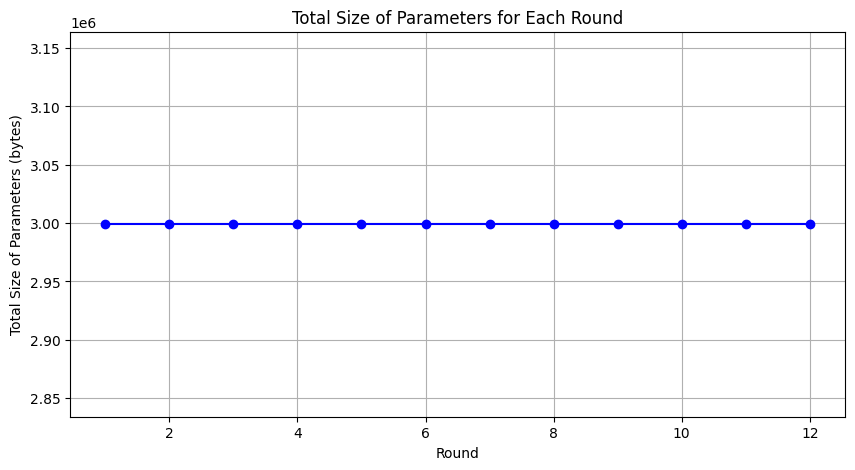

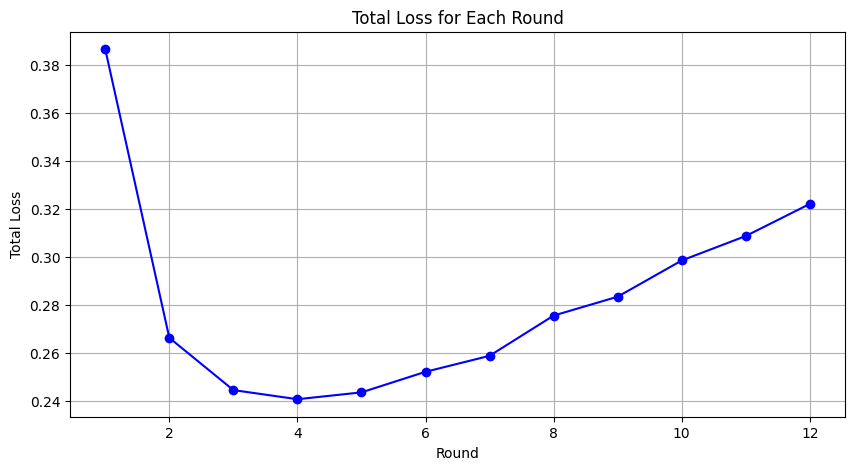

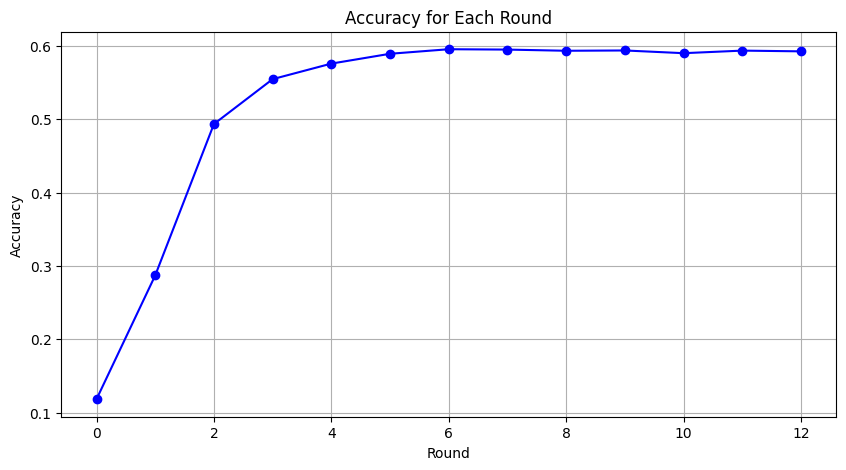

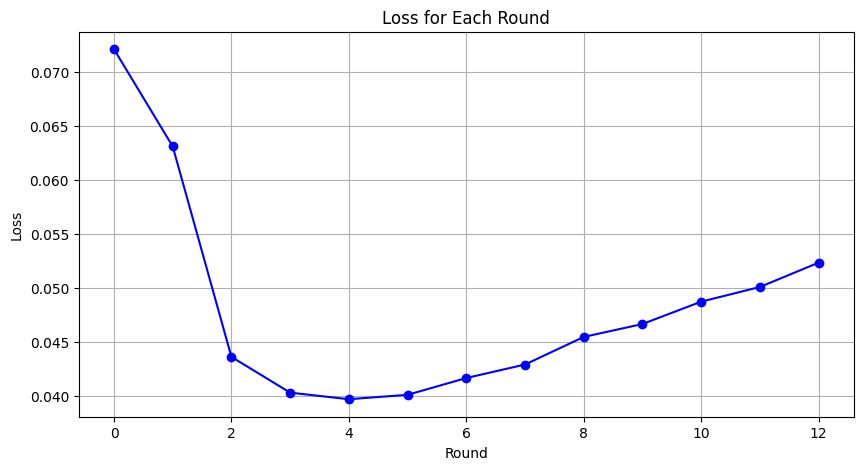

In [10]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.grid(True)

# FedAvgPart Experiments

In [8]:
from typing import Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

fed_part_avg_result = {}

fed_part_avg_model_results = {}


class FedPartAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

        self.layer_update_strategy = layer_update_strategy  # 'sequential' or 'cyclic'
        self.current_layer = 0  # Track which layer to update
        self.number_of_layers = None
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters
        self.updated_layers = -1
       


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        self.layer_training_sequence = self.generate_layer_training_sequence()
        self.number_of_layers = len(ndarrays)

        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_avg_model_results:  
            expand_fed_part_avg_model_results= {**fed_part_avg_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_avg_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_avg_model_results[server_round] = expand_fed_part_avg_model_results
        
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index], "updated_layers": self.updated_layers}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []

        params_array = parameters_to_ndarrays(parameters)
        
        # If doing full model update, send all parameters
        if self.layer_training_sequence[self.training_sequence_index] == -1 or self.updated_layers == -1:
            selected_params = parameters
        else:
            layer_idx = self.updated_layers
            selected_params = ndarrays_to_parameters([
                    params_array[layer_idx * 2],     # Weight
                    params_array[layer_idx * 2 + 1]  # Bias
                ])


        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(selected_params, config)))

        self.updated_layers = self.layer_training_sequence[self.training_sequence_index]
        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
            total_size += fit_res.metrics["recieved_parameter_size"]
            
        print(f"total size: {total_size}")
        
        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_size"] = total_size
        else:
            fed_part_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        trained_layer = results[0][1].metrics["trained_layer"]
        print(f"aggregated weight size {len(aggregated_weights)} ")

        if trained_layer == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            print(f"updateing layers {trained_layer* 2}  and {trained_layer* 2 + 1} ")
            current_model[trained_layer* 2] = aggregated_weights[0]
            current_model[trained_layer* 2 +1] = aggregated_weights[1]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    

In [9]:

class FedAvgPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader, context: Context):
        print(f"[Client {partition_id}] initialized")
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.client_state = context.state

        # Initialize parameters record if it doesn't exist
        if "net_parameters" not in self.client_state.parameters_records:
            self.client_state.parameters_records["net_parameters"] = ParametersRecord()
            # Save initial model state
            self._save_model_state()

    def _save_model_state(self):
        """Save current model parameters to context"""
        p_record = ParametersRecord()
        parameters = get_parameters(self.net)
        
        for i, param in enumerate(parameters):
            p_record[f"layer_{i}"] = array_from_numpy(param)
        
        self.client_state.parameters_records["net_parameters"] = p_record

    def _load_model_state(self):
        """Load model parameters from context"""
        p_record = self.client_state.parameters_records["net_parameters"]
        parameters = []
        
        for i in range(len(p_record)):
            parameters.append(p_record[f"layer_{i}"].numpy())
        
        set_parameters(self.net, parameters)

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        trainable_layer = config["trainable_layers"]
        self._save_model_state()
        
        if trainable_layer == -1:
            return parameters
        
        trained_layer = [parameters[trainable_layer*2], parameters[trainable_layer*2 +1]]
        return trained_layer

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        
        self._load_model_state()
        recieved_parameter_size = get_parameters_size(ndarrays_to_parameters(parameters))  
        set_parameters(self.net, parameters, config["updated_layers"])
        freeze_layers(self.net, config["trainable_layers"])
        train(self.net, self.trainloader, epochs=EPOCHS)
        
        self._save_model_state()
        
        return self.get_parameters(config), len(self.trainloader), {"trained_layer":config["trainable_layers"], "recieved_parameter_size": recieved_parameter_size}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate")
        self._load_model_state()
        current_state = get_parameters(self.net)
        set_parameters(self.net, current_state)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    
    # Initialize network if not in context
    if not hasattr(context, 'net'):
        context.net = Net().to(DEVICE)
    
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    
    return FedAvgPartFlowerClient(
        partition_id=partition_id,
        net=context.net,
        trainloader=trainloader,
        valloader=valloader,
        context=context
    ).to_client()

# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [ ]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartAvg(
            evaluate_fn=evaluate_fn,
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07208577201366424, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]
(ClientAppActor pid=99387) [Client 4] initialized
(ClientAppActor pid=99387) [Client 4] fit, config: {'updated_layers': -1, 'trainable_layers': -1}
(ClientAppActor pid=99387) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=99387) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=99387) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=99387) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=99387) layer index is 4 and nameconv3.weight is trainabe
(ClientAppActor pid=99387) layer index is 5 and nameconv3.bias is trainabe
(ClientAppActor pid=99387) layer index is 6 and nameconv4.weight is trainabe
(ClientAppActor pid=99387) layer index is 7 and nameconv4.bias is trainabe
(ClientAppActor pid=99387) layer index is 8 and nameconv5.weight is trainabe
(ClientAppActor pid=99387) layer index is 9 and nameconv5.bias is trainabe
(ClientAppA

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=99382) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=99382) Epoch 8: train loss 0.04308599606156349, accuracy 0.4810981098109811 [repeated 4x across cluster]
total size: 280903296
aggregated weight size 18 


INFO :      fit progress: (1, 0.07239897840023041, {'accuracy': 0.1}, 826.5800111249999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=99387) [Client 3] initialized
(ClientAppActor pid=99387) [Client 3] evaluate
(ClientAppActor pid=99386) 


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]
(ClientAppActor pid=99386) [Client 1] fit, config: {'updated_layers': -1, 'trainable_layers': -1}
(ClientAppActor pid=99386) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=99386) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=99386) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=99386) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=99386) layer index is 4 and nameconv3.weight is trainabe
(ClientAppActor pid=99386) layer index is 5 and nameconv3.bias is trainabe
(ClientAppActor pid=99386) layer index is 6 and nameconv4.weight is trainabe
(ClientAppActor pid=99386) layer index is 7 and nameconv4.bias is trainabe
(ClientAppActor pid=99386) layer index is 8 and nameconv5.weight is trainabe
(ClientAppActor pid=99386) layer index is 9 and nameconv5.bias is trainabe
(ClientAppActor pid=99386) layer index is 10 and nameconv6.we

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=99388) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=99388) Epoch 8: train loss 0.07218536734580994, accuracy 0.10501050105010501 [repeated 4x across cluster]
total size: 280903296
aggregated weight size 18 


INFO :      fit progress: (2, 0.07207168128490447, {'accuracy': 0.1}, 1625.386986166)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=99384) [Client 5] initialized
(ClientAppActor pid=99384) [Client 5] evaluate


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]
(ClientAppActor pid=99388) [Client 4] fit, config: {'updated_layers': -1, 'trainable_layers': 0}
(ClientAppActor pid=99388) [Client 4] initialized [repeated 6x across cluster]
(ClientAppActor pid=99385) [Client 1] evaluate [repeated 5x across cluster]
(ClientAppActor pid=99388) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=99388) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=99388) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=99388) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=99388) layer index is 4 and nameconv3.weight is frozen
(ClientAppActor pid=99388) layer index is 5 and nameconv3.bias is frozen
(ClientAppActor pid=99388) layer index is 6 and nameconv4.weight is frozen
(ClientAppActor pid=99388) layer index is 7 and nameconv4.bias is frozen
(ClientAppActor pid=99388) layer index is 8 and nameconv5.weight is fro

(raylet) [2025-03-13 10:57:17,564 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24072073216; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 10:57:27,599 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24051163136; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 10:57:37,606 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24050577408; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 10:57:47,615 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24050421760; capacity: 494384795648. Object 

(ClientAppActor pid=99386) Epoch 1: train loss 0.0721929520368576, accuracy 0.10546054605460546
(ClientAppActor pid=99387) [Client 3] fit, config: {'updated_layers': -1, 'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=99387) [Client 3] initialized [repeated 5x across cluster]
(ClientAppActor pid=99387) layer index is 1 and nameconv1.bias is trainabe [repeated 10x across cluster]
(ClientAppActor pid=99387) layer index is 17 and namefc3.bias is frozen [repeated 80x across cluster]


(raylet) [2025-03-13 10:58:37,956 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24062353408; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 10:58:48,023 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24058351616; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 10:58:58,074 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24058179584; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 10:59:08,094 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24058175488; capacity: 494384795648. Object 

(ClientAppActor pid=99386) Epoch 2: train loss 0.07219275087118149, accuracy 0.10546054605460546 [repeated 6x across cluster]


(raylet) [2025-03-13 10:59:48,336 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24057565184; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 10:59:58,379 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24057487360; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:00:08,476 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24057200640; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:00:18,544 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24057167872; capacity: 494384795648. Object 

(ClientAppActor pid=99386) Epoch 3: train loss 0.07219279557466507, accuracy 0.10546054605460546 [repeated 6x across cluster]


(raylet) [2025-03-13 11:01:18,922 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24069304320; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:01:28,965 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24067411968; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:01:39,026 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24067309568; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:01:49,034 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24067309568; capacity: 494384795648. Object 

(ClientAppActor pid=99386) Epoch 4: train loss 0.07219240814447403, accuracy 0.10546054605460546 [repeated 6x across cluster]


(raylet) [2025-03-13 11:02:39,228 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24066088960; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:02:49,248 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24064995328; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:02:59,288 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24064929792; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:03:09,297 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24060887040; capacity: 494384795648. Object 

(ClientAppActor pid=99385) Epoch 5: train loss 0.07219351083040237, accuracy 0.09735973597359736 [repeated 6x across cluster]


(raylet) [2025-03-13 11:03:49,366 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24060497920; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:03:59,406 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24058351616; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:04:09,434 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24058220544; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:04:19,487 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24055558144; capacity: 494384795648. Object 

(ClientAppActor pid=99385) Epoch 6: train loss 0.07219351828098297, accuracy 0.09735973597359736 [repeated 6x across cluster]


(raylet) [2025-03-13 11:04:59,677 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24073256960; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:05:09,678 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24073256960; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:05:19,701 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24073199616; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2025-03-13 11:05:29,732 E 99369 3576042] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-03-13_10-29-24_487379_99354 is over 95% full, available space: 24073015296; capacity: 494384795648. Object 

(ClientAppActor pid=99388) Epoch 6: train loss 0.0721941590309143, accuracy 0.09960996099609962 [repeated 5x across cluster]


Text(0.5, 1.0, 'Loss for Each Round')

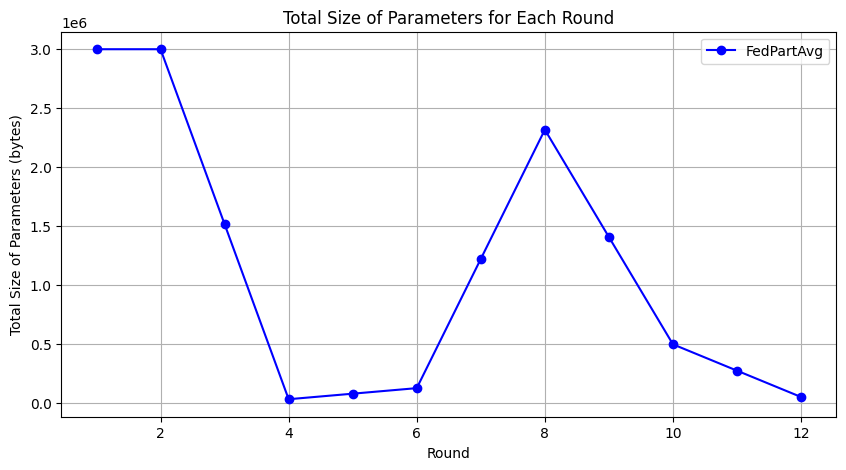

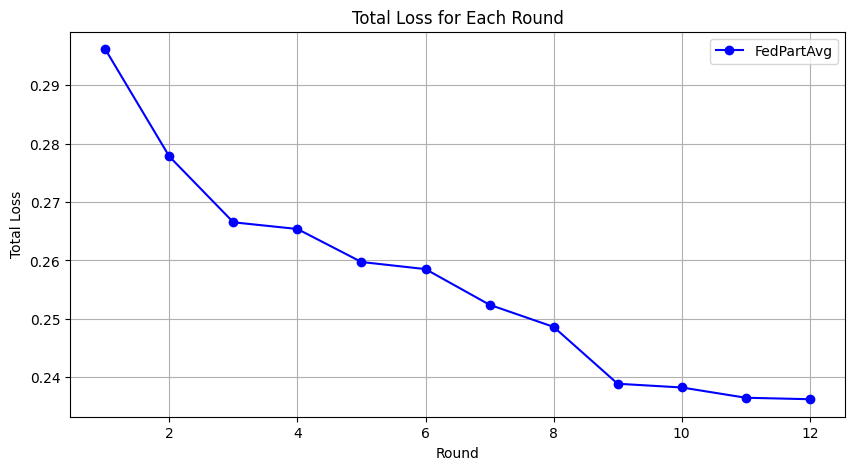

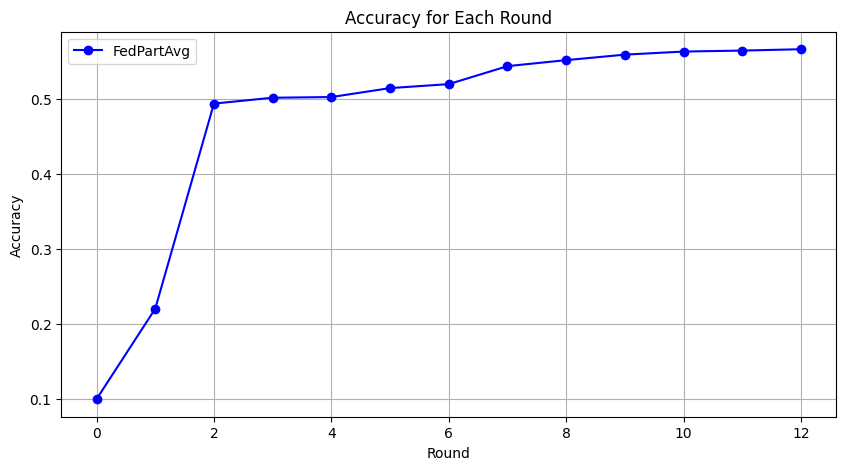

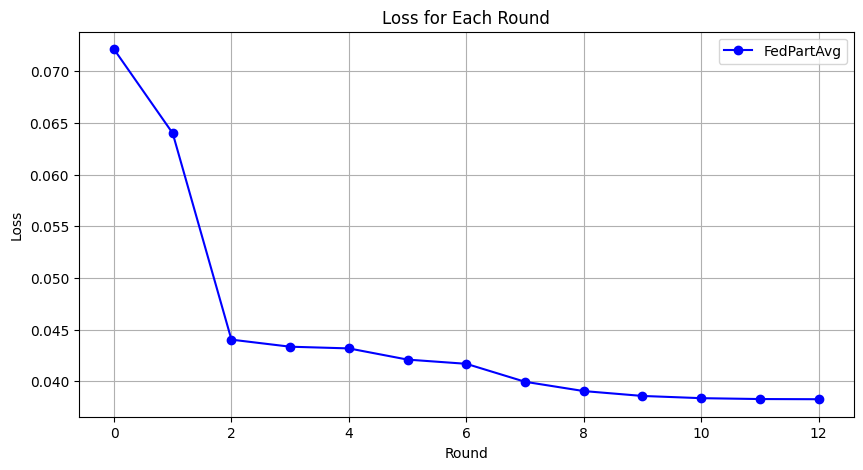

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_part_avg_rounds = list(fed_part_avg_result.keys())
fed_part_avg_sizes = [fed_part_avg_result[round]["total_size"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_losses = [fed_part_avg_result[round]["total_loss"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_avg_model_rounds = list(fed_part_avg_model_results.keys())
fed_part_avg_accuracies = [fed_part_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_global_losses = [fed_part_avg_model_results[round]["global_loss"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss for Each Round')


# FedProx experiments:

In [15]:
class FedProxFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [16]:
fed_prox_result = {}

fed_prox_model_results = {}

class ModifiedFedProx(ModifiedFedAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "ModifiedFedProx"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters) *2
        print(f"total size: {total_size}")
        
        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_size"] = total_size
        else:
            fed_prox_result[server_round] = {"total_size": total_size}
        

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_prox_model_results:  
            expand_fed_prox_model_results= {**fed_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_prox_model_results[server_round] = expand_fed_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [17]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=12, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07211912546157837, {'accuracy': 0.1081}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54427) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=54427)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=54427) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54432) Epoch 1: train loss 0.06387756764888763, accuracy 0.2369881505924704
(ClientAppActor pid=54429) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54430) Epoch 3: train loss 0.05009186640381813, accuracy 0.41134113411341133 [repeated 12x across cluster]
(ClientAppActor pid=54430) Epoch 5: train loss 0.04472823068499565, accuracy 0.47134713471347134 [repeated 12x across cluster]
(ClientAppActor pid=54430) Epoch 7: train loss 0.039838336408138275, accuracy 0.5411041104110411 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (1, 0.056712698602676394, {'accuracy': 0.3384}, 36.85920025000814)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54432) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=54432)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=54432) [Client 1] evaluate, config: {}
(ClientAppActor pid=54426) Epoch 8: train loss 0.03713664785027504, accuracy 0.5697569756975698 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54430) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54429) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54430) Epoch 1: train loss 0.04712151363492012, accuracy 0.45124512451245125
(ClientAppActor pid=54432) Epoch 1: train loss 0.04652805253863335, accuracy 0.4582958295829583
(ClientAppActor pid=54428) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54430) Epoch 3: train loss 0.04011717438697815, accuracy 0.5333033303330333 [repeated 11x across cluster]
(ClientAppActor pid=54430) Epoch 5: train loss 0.03505444899201393, accuracy 0.599009900990099 [repeated 12x across cluster]
(ClientAppActor pid=54430) Epoch 7: train loss 0.030694354325532913, accuracy 0.6449144914491449 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (2, 0.03895248566865921, {'accuracy': 0.5654}, 68.90633629198419)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54426) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54426)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=54426) [Client 1] evaluate, config: {}
(ClientAppActor pid=54428) Epoch 8: train loss 0.028012098744511604, accuracy 0.6739163041847908 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54427) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54432) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54429) Epoch 1: train loss 0.038220833986997604, accuracy 0.5625562556255626
(ClientAppActor pid=54427) Epoch 1: train loss 0.036936722695827484, accuracy 0.5771077107710771
(ClientAppActor pid=54428) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54429) Epoch 3: train loss 0.03138560429215431, accuracy 0.6324632463246325 [repeated 11x across cluster]
(ClientAppActor pid=54429) Epoch 5: train loss 0.026199689134955406, accuracy 0.6968196819681968 [repeated 12x across cluster]
(ClientAppActor pid=54429) Epoch 7: train loss 0.02059943787753582, accuracy 0.7707770777077708 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (3, 0.040486085534095766, {'accuracy': 0.5859}, 102.29564220801694)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54427) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54427)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=54432) [Client 3] evaluate, config: {}
(ClientAppActor pid=54428) Epoch 8: train loss 0.01787230558693409, accuracy 0.791660416979151 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54428) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54429) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54428) Epoch 1: train loss 0.03428659215569496, accuracy 0.6128112811281128
(ClientAppActor pid=54430) Epoch 1: train loss 0.03506528586149216, accuracy 0.6106194690265486
(ClientAppActor pid=54432) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54428) Epoch 3: train loss 0.024204032495617867, accuracy 0.7257725772577258 [repeated 11x across cluster]
(ClientAppActor pid=54428) Epoch 5: train loss 0.017928428947925568, accuracy 0.8022802280228023 [repeated 12x across cluster]
(ClientAppActor pid=54428) Epoch 7: train loss 0.012160715647041798, accuracy 0.8618361836183618 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (4, 0.046620028793811795, {'accuracy': 0.593}, 134.3251667919685)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54427) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54427)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=54427) [Client 1] evaluate, config: {}
(ClientAppActor pid=54432) Epoch 8: train loss 0.009868902154266834, accuracy 0.8960396039603961 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54428) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54429) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54428) Epoch 1: train loss 0.032367024570703506, accuracy 0.6333633363336334
(ClientAppActor pid=54430) Epoch 1: train loss 0.03104887716472149, accuracy 0.6494149414941495
(ClientAppActor pid=54426) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54428) Epoch 3: train loss 0.018781501799821854, accuracy 0.7887788778877888 [repeated 11x across cluster]
(ClientAppActor pid=54428) Epoch 5: train loss 0.01197456568479538, accuracy 0.8708370837083709 [repeated 12x across cluster]
(ClientAppActor pid=54428) Epoch 7: train loss 0.007744007743895054, accuracy 0.92004200420042 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (5, 0.05313013665676117, {'accuracy': 0.5922}, 168.6324555419851)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54430) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54430)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=54430) [Client 4] evaluate, config: {}
(ClientAppActor pid=54426) Epoch 8: train loss 0.007518426515161991, accuracy 0.9185418541854186 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54432) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54432) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54432) Epoch 1: train loss 0.031827595084905624, accuracy 0.6613169341532923
(ClientAppActor pid=54429) Epoch 1: train loss 0.03155261278152466, accuracy 0.6576657665766577
(ClientAppActor pid=54427) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54432) Epoch 3: train loss 0.016103088855743408, accuracy 0.8197090145492726 [repeated 11x across cluster]
(ClientAppActor pid=54432) Epoch 5: train loss 0.009894345887005329, accuracy 0.896205189740513 [repeated 12x across cluster]
(ClientAppActor pid=54432) Epoch 7: train loss 0.006437833420932293, accuracy 0.9301034948252588 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (6, 0.06118669711947441, {'accuracy': 0.591}, 201.21132145798765)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54427) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54427)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=54428) [Client 2] evaluate, config: {}
(ClientAppActor pid=54427) Epoch 8: train loss 0.0042618135921657085, accuracy 0.959502024898755 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54429) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54432) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54429) Epoch 1: train loss 0.029571665450930595, accuracy 0.6857657117144143
(ClientAppActor pid=54427) Epoch 1: train loss 0.02857557125389576, accuracy 0.695019501950195
(ClientAppActor pid=54426) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54429) Epoch 3: train loss 0.011559954844415188, accuracy 0.8705564721763912 [repeated 11x across cluster]
(ClientAppActor pid=54429) Epoch 5: train loss 0.005923365242779255, accuracy 0.9403029848507575 [repeated 12x across cluster]
(ClientAppActor pid=54429) Epoch 7: train loss 0.003894473658874631, accuracy 0.9616019199040048 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (7, 0.06609973304867744, {'accuracy': 0.5857}, 235.22932341700653)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54430) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54430)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=54428) [Client 1] evaluate, config: {}
(ClientAppActor pid=54426) Epoch 8: train loss 0.00387750961817801, accuracy 0.9611461146114612 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54432) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54429) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54427) Epoch 1: train loss 0.02807634137570858, accuracy 0.7047704770477048
(ClientAppActor pid=54432) Epoch 1: train loss 0.02810611203312874, accuracy 0.704514774261287
(ClientAppActor pid=54430) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54432) Epoch 3: train loss 0.009542332030832767, accuracy 0.8951552422378881 [repeated 11x across cluster]
(ClientAppActor pid=54432) Epoch 5: train loss 0.005142781417816877, accuracy 0.9475026248687566 [repeated 12x across cluster]
(ClientAppActor pid=54428) Epoch 7: train loss 0.00396836269646883, accuracy 0.960996099609961 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (8, 0.07099703691005707, {'accuracy': 0.577}, 267.23408133297926)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54426) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54426)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=54426) [Client 0] evaluate, config: {}
(ClientAppActor pid=54426) Epoch 8: train loss 0.004188820719718933, accuracy 0.9537953795379538 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54430) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54427) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54430) Epoch 1: train loss 0.029028410091996193, accuracy 0.7067206720672067
(ClientAppActor pid=54426) Epoch 1: train loss 0.027536867186427116, accuracy 0.716021602160216
(ClientAppActor pid=54427) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54430) Epoch 3: train loss 0.008697443641722202, accuracy 0.9047404740474048 [repeated 11x across cluster]
(ClientAppActor pid=54430) Epoch 5: train loss 0.004676067270338535, accuracy 0.9545454545454546 [repeated 12x across cluster]
(ClientAppActor pid=54430) Epoch 7: train loss 0.003117502899840474, accuracy 0.968046804680468 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (9, 0.07432863339185715, {'accuracy': 0.5774}, 298.4527619999717)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54429) [Client 4] evaluate, config: {}
(ClientAppActor pid=54426) Epoch 8: train loss 0.00477793300524354, accuracy 0.9486948694869487 [repeated 11x across cluster]


(ClientAppActor pid=54429) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54429)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54432) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54432) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54432) Epoch 1: train loss 0.0277637280523777, accuracy 0.7225138743062847
(ClientAppActor pid=54430) Epoch 1: train loss 0.027758276090025902, accuracy 0.723972397239724
(ClientAppActor pid=54428) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54432) Epoch 3: train loss 0.007470282260328531, accuracy 0.9226038698065097 [repeated 11x across cluster]
(ClientAppActor pid=54430) Epoch 5: train loss 0.0035173571668565273, accuracy 0.966996699669967 [repeated 12x across cluster]
(ClientAppActor pid=54427) Epoch 7: train loss 0.004466905724257231, accuracy 0.9532023398830058 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (10, 0.07517245024442673, {'accuracy': 0.5752}, 331.4416724999901)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54428) [Client 5] evaluate, config: {}
(ClientAppActor pid=54426) Epoch 8: train loss 0.003989404067397118, accuracy 0.9533453345334534 [repeated 11x across cluster]


(ClientAppActor pid=54428) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54428)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54427) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54427) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54427) Epoch 1: train loss 0.025369910523295403, accuracy 0.7435128243587821
(ClientAppActor pid=54428) Epoch 1: train loss 0.025060590356588364, accuracy 0.7431743174317432
(ClientAppActor pid=54426) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54428) Epoch 3: train loss 0.0055884672328829765, accuracy 0.9444944494449445 [repeated 11x across cluster]
(ClientAppActor pid=54428) Epoch 5: train loss 0.0028506896924227476, accuracy 0.9735973597359736 [repeated 12x across cluster]
(ClientAppActor pid=54428) Epoch 7: train loss 0.004991228226572275, accuracy 0.9474947494749475 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (11, 0.07998749957680702, {'accuracy': 0.5758}, 363.2075560829835)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54432) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54432)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=54426) [Client 0] evaluate, config: {}
(ClientAppActor pid=54426) Epoch 8: train loss 0.0035383200738579035, accuracy 0.9638463846384638 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=54428) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=54428) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54428) Epoch 1: train loss 0.025199098512530327, accuracy 0.7489125543722814
(ClientAppActor pid=54430) Epoch 1: train loss 0.0236464012414217, accuracy 0.7577257725772577
(ClientAppActor pid=54426) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=54428) Epoch 3: train loss 0.005194682627916336, accuracy 0.9475026248687566 [repeated 11x across cluster]
(ClientAppActor pid=54428) Epoch 5: train loss 0.0030563243199139833, accuracy 0.9698515074246288 [repeated 12x across cluster]
(ClientAppActor pid=54428) Epoch 7: train loss 0.0051567936316132545, accuracy 0.9451027448627569 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040


INFO :      fit progress: (12, 0.08030362340211868, {'accuracy': 0.5742}, 395.98772420798196)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=54427) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=54427)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=54427) [Client 3] evaluate, config: {}
(ClientAppActor pid=54426) Epoch 8: train loss 0.0038592962082475424, accuracy 0.95994599459946 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 12 round(s) in 398.99s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.058014831407574075
INFO :      		round 2: 0.04009017698247774
INFO :      		round 3: 0.04176053830449091
INFO :      		round 4: 0.04733354984370143
INFO :      		round 5: 0.0540697987529754
INFO :      		round 6: 0.06238581495383005
INFO :      		round 7: 0.06748826806097359
INFO :      		round 8: 0.07228130147746029
INFO :      		round 9: 0.07587440377684193
INFO :      		round 10: 0.07652854307267314
INFO :      		round 11: 0.08174633048661016
INFO :      		round 12: 0.08209582831665138
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07211912546157837
INFO :      		round 1: 0.056712698602676394
INFO :      		round 2: 0.03895248566865921
INFO :      		round 3: 0.040486085534095766
INFO :      		round 4: 0.046620028793811795
INFO :      		round 5: 0.05313

(ClientAppActor pid=54426) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=54426) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=54426)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


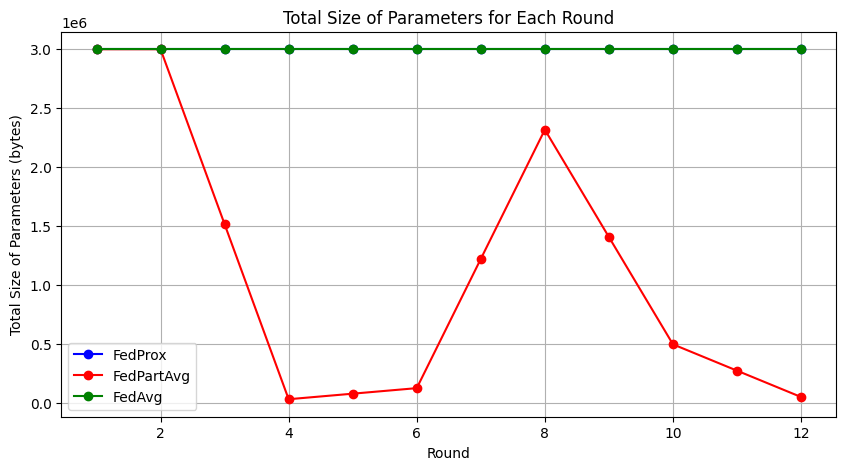

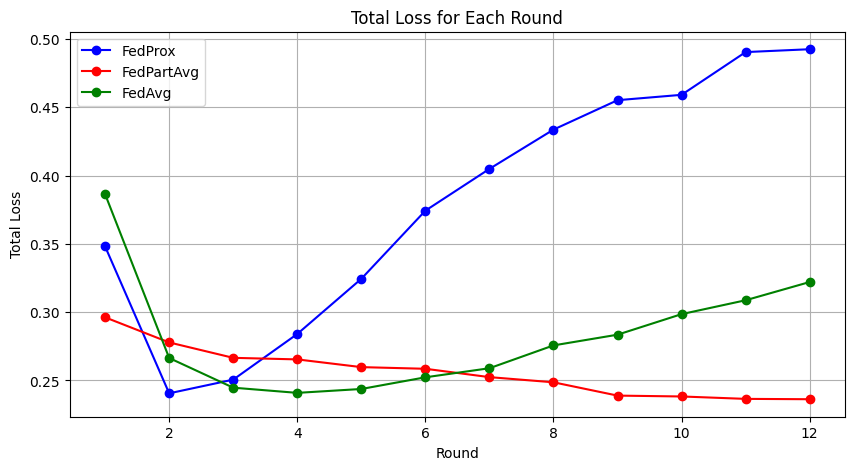

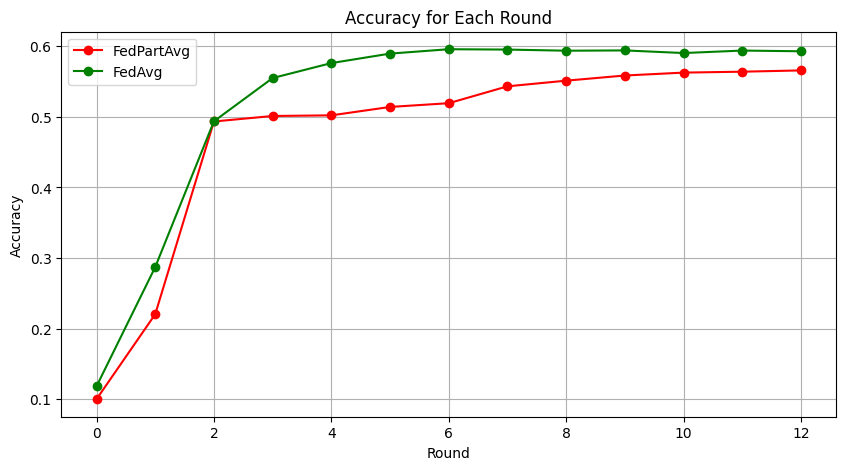

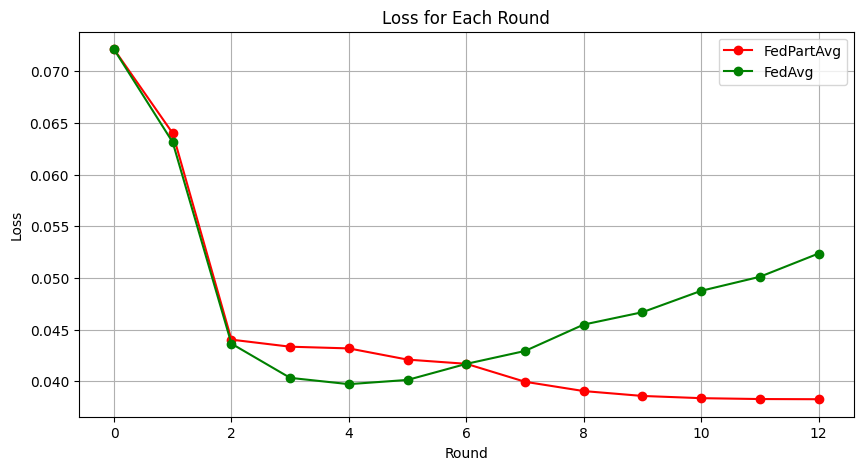

In [19]:
fed_prox_rounds = list(fed_prox_result.keys())
fed_prox_sizes = [fed_prox_result[round]["total_size"] for round in fed_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='b', label='FedProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_prox_losses = [fed_prox_result[round]["total_loss"] for round in fed_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='b', label='FedProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_prox_model_rounds = list(fed_prox_model_results.keys())
fed_prox_accuracies = [fed_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_prox_model_rounds]

plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_prox_global_losses = [fed_prox_model_results[round]["global_loss"] for round in fed_prox_model_rounds]

plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.legend()
plt.grid(True)


# FedProxPart Experiments

In [47]:
class FedProxPartFlowerClient(FedAvgPartFlowerClient):
    def __init__(self, partition_id, net, trainloader, valloader, context: Context):
        super().__init__(partition_id, net, trainloader, valloader, context)



    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config} with parameters size {parameters}")
        self._load_model_state()
        
        recieved_parameter_size = get_parameters_size(ndarrays_to_parameters(parameters))     
        # recieved_parameter_size = 1  
        set_parameters(self.net, parameters, config["updated_layers"])
        global_params = copy.deepcopy(self.net).parameters()
        freeze_layers(self.net, config["trainable_layers"])
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        self._save_model_state()
        return self.get_parameters(config), len(self.trainloader), {"trained_layer":config["trainable_layers"], "recieved_parameter_size": recieved_parameter_size}


def client_fn(context: Context) -> Client:

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    if not hasattr(context, "net"): 
        context.net = Net().to(DEVICE)

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, context.net, trainloader, valloader, context).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [49]:
fed_part_prox_result = {}

fed_part_prox_model_results = {}

class FedPartProx(FedPartAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "FedPartProx"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
            total_size += fit_res.metrics["recieved_parameter_size"]

        print(f"total size: {total_size}")
        
        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_size"] = total_size
        else:
            fed_part_prox_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        trained_layer = results[0][1].metrics["trained_layer"]
        print(f"aggregated weight size {len(aggregated_weights)} ")

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            print(f"updateing layers {self.layer_training_sequence[self.training_sequence_index -1]* 2}  and {self.layer_training_sequence[self.training_sequence_index -1]* 2 + 1} ")
            current_model[self.layer_training_sequence[self.training_sequence_index -1]* 2] = aggregated_weights[0]
            current_model[self.layer_training_sequence[self.training_sequence_index -1]* 2 +1] = aggregated_weights[1]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated
    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_prox_model_results:  
            expand_fed_part_prox_model_results= {**fed_part_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_prox_model_results[server_round] = expand_fed_part_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [50]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=12, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07213858127593994, {'accuracy': 0.0556}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36756) [Client 4] initialized
(ClientAppActor pid=36756) [Client 4] fit, config: {'proximal_mu': 0.1, 'updated_layers': -1, 'trainable_layers': -1} with parameters size [array([[[[ 4.45733033e-02, -5.02156876e-02,  4.73946258e-02,
(ClientAppActor pid=36756)           -1.63508914e-02,  2.74507818e-03],
(ClientAppActor pid=36756)          [ 2.55609564e-02,  4.25841883e-02, -1.07699059e-01,
(ClientAppActor pid=36756)            4.80277799e-02, -1.07485577e-01],
(ClientAppActor pid=36756)          [-4.91959117e-02,  8.82081315e-02,  6.36113882e-02,
(ClientAppActor pid=36756)            4.22621146e-02, -7.94648230e-02],
(ClientAppActor pid=36756)          [ 7.10338056e-02,  6.45760372e-02, -5.36387637e-02,
(ClientAppActor pid=36756)           -2.07542237e-02,  2.11406518e-02],
(ClientAppActor pid=36756)          [ 7.08448812e-02, -1.03549100e-01, -2.30735876e-02,
(ClientAppActor pid=36756)           -5.25127240e-02

(ClientAppActor pid=36756) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=36756)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=36757)           -1.63508914e-02,  2.74507818e-03],
(ClientAppActor pid=36757)            4.80277799e-02, -1.07485577e-01],
(ClientAppActor pid=36757)          [-4.91959117e-02,  8.82081315e-02,  6.36113882e-02,
(ClientAppActor pid=36757)            4.22621146e-02, -7.94648230e-02],
(ClientAppActor pid=36757)           -2.07542237e-02,  2.11406518e-02],
(ClientAppActor pid=36757)           -5.25127240e-02, -1.15404792e-01]],
(ClientAppActor pid=36757) 
(ClientAppActor pid=36757)         [[-1.08965255e-01, -3.70803662e-02,  2.91302614e-02,
(ClientAppActor pid=36757)           -1.10493392e-01,  7.62325823e-02],
(ClientAppActor pid=36757)          [-3.92293595e-02,  4.42653634e-02, -9.69084874e-02,
(ClientAppActor pid=36757)            2.80820765e-02, -6.85962737e-02],
(ClientAppActor pid=36757)          [-5.19003719e-02,  7.10832551e-02,  9.90360454e-02,
(ClientAppActor pid=36757)           -7.74060041e-02, -5.07388562e-02],
(ClientAppActor pid=36757)           -2.843

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040
aggregated weight size 10 


INFO :      fit progress: (1, 0.05427626827955246, {'accuracy': 0.3978}, 34.821236124960706)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36759) [Client 4] initialized
(ClientAppActor pid=36759) [Client 4] evaluate
(ClientAppActor pid=36758) Epoch 8: train loss 0.038316626101732254, accuracy 0.5529552955295529 [repeated 11x across cluster]
(ClientAppActor pid=36758) [Client 2] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36759) [Client 0] fit, config: {'proximal_mu': 0.1, 'updated_layers': -1, 'trainable_layers': -1} with parameters size [array([[[[ 2.35838652e-01,  1.37711421e-01,  2.21611351e-01,
(ClientAppActor pid=36759)            1.25672117e-01,  1.37429446e-01],
(ClientAppActor pid=36759)          [ 1.46049291e-01,  1.42063871e-01, -4.40754294e-02,
(ClientAppActor pid=36759)            8.26072618e-02, -5.49946465e-02],
(ClientAppActor pid=36759)          [ 4.54698689e-03,  1.05206259e-01,  3.34387384e-02,
(ClientAppActor pid=36759)           -1.86287693e-03, -7.58923292e-02],
(ClientAppActor pid=36759)          [ 4.08865735e-02, -7.88875110e-03, -1.63519233e-01,
(ClientAppActor pid=36759)           -1.28673792e-01, -1.55102294e-02],
(ClientAppActor pid=36759)          [-9.81261488e-03, -2.29301170e-01, -1.69768721e-01,
(ClientAppActor pid=36759)           -1.80338293e-01, -1.68516919e-01]],
(ClientAppActor pid=36759) 
(

(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=36760)            1.25672117e-01,  1.37429446e-01],
(ClientAppActor pid=36760)            8.26072618e-02, -5.49946465e-02],
(ClientAppActor pid=36760)           -1.86287693e-03, -7.58923292e-02],
(ClientAppActor pid=36760)           -1.28673792e-01, -1.55102294e-02],
(ClientAppActor pid=36760)          [-9.81261488e-03, -2.29301170e-01, -1.69768721e-01,
(ClientAppActor pid=36760)           -1.80338293e-01, -1.68516919e-01]],
(ClientAppActor pid=36760) 
(ClientAppActor pid=36760)         [[-1.26149610e-01, -6.45218641e-02, -1.26526346e-02,
(ClientAppActor pid=36760)           -1.81338325e-01,  9.95511562e-03],
(ClientAppActor pid=36760)          [-6.79024756e-02, -1.19061526e-02, -1.81050152e-01,
(ClientAppActor pid=36760)           -7.36881569e-02, -1.42239884e-01],
(ClientAppActor pid=36760)          [-6.65863901e-02,  1.47323543e-02,  1.78922701e-03,
(ClientAppActor pid=36760)           -1.75116271e-01, -9.81142521e-02],
(ClientAppActor pid=36760)           -1.205

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2999040
aggregated weight size 10 


INFO :      fit progress: (2, 0.038819984930753705, {'accuracy': 0.5581}, 68.44721004198072)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36757) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=36757)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=36756) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=36756)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=36757) [Client 4] initialized
(ClientAppActor pid=36757) [Client 4] evaluate
(ClientAppActor pid=36760) Epoch 8: train loss 0.02853148803114891, accuracy 0.6776177617761776 [repeated 11x across cluster]
(ClientAppActor pid=36760) [Client 3] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36757) [Client 3] fit, config: {'proximal_mu': 0.1, 'updated_layers': -1, 'trainable_layers': 0} with parameters size [array([[[[ 2.96648324e-01,  2.06392571e-01,  2.81089902e-01,
(ClientAppActor pid=36757)            1.62524074e-01,  1.75173327e-01],
(ClientAppActor pid=36757)          [ 2.00071439e-01,  1.91390336e-01, -6.30938774e-03,
(ClientAppActor pid=36757)            9.57127213e-02, -1.94587838e-02],
(ClientAppActor pid=36757)          [ 5.44066317e-02,  1.39380395e-01,  2.71991938e-02,
(ClientAppActor pid=36757)           -2.93543451e-02, -5.77281229e-02],
(ClientAppActor pid=36757)          [ 7.12141469e-02,  7.50486087e-03, -1.95380032e-01,
(ClientAppActor pid=36757)           -1.76212698e-01, -9.47687775e-03],
(ClientAppActor pid=36757)          [-3.07832677e-02, -2.57497311e-01, -2.25612178e-01,
(ClientAppActor pid=36757)           -2.39213839e-01, -1.82093427e-01]],
(ClientAppActor pid=36757) 
(C

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1513536
aggregated weight size 2 
updateing layers 0  and 1 


INFO :      fit progress: (3, 0.038103960686922074, {'accuracy': 0.5684}, 101.46735374996206)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36759) [Client 3] initialized
(ClientAppActor pid=36759) [Client 3] evaluate
(ClientAppActor pid=36758) Epoch 8: train loss 0.036081042140722275, accuracy 0.5965201739913004 [repeated 11x across cluster]
(ClientAppActor pid=36758) [Client 0] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=36759) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=36759)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36757) [Client 4] fit, config: {'proximal_mu': 0.1, 'updated_layers': 0, 'trainable_layers': 0} with parameters size [array([[[[ 0.27067894,  0.19165745,  0.2723433 ,  0.14662886,
(ClientAppActor pid=36757)            0.16428037],
(ClientAppActor pid=36757)          [ 0.1701248 ,  0.18679783,  0.0153518 ,  0.10170182,
(ClientAppActor pid=36757)            0.01093049],
(ClientAppActor pid=36757)          [ 0.0395016 ,  0.1615616 ,  0.04599851, -0.02916826,
(ClientAppActor pid=36757)           -0.02010804],
(ClientAppActor pid=36757)          [ 0.07076877,  0.04678812, -0.18773162, -0.19339   ,
(ClientAppActor pid=36757)            0.01354809],
(ClientAppActor pid=36757)          [-0.04854797, -0.24386667, -0.23310329, -0.2627485 ,
(ClientAppActor pid=36757)           -0.17662589]],
(ClientAppActor pid=36757) 
(ClientAppActor pid=36757)         [[-0.16755852, -0.11036417, -0.07925331, -0.28149635,
(ClientAppActo

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 28032
aggregated weight size 2 
updateing layers 0  and 1 


INFO :      fit progress: (4, 0.03790467756390572, {'accuracy': 0.5705}, 131.72802112495992)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=36760) [Client 2] initialized
(ClientAppActor pid=36760) [Client 2] evaluate
(ClientAppActor pid=36756) Epoch 8: train loss 0.03547351807355881, accuracy 0.5924092409240924 [repeated 11x across cluster]
(ClientAppActor pid=36756) [Client 3] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36756) [Client 4] fit, config: {'proximal_mu': 0.1, 'updated_layers': 0, 'trainable_layers': 1} with parameters size [array([[[[ 2.66986907e-01,  1.96657285e-01,  2.79625088e-01,
(ClientAppActor pid=36756)            1.40521944e-01,  1.52723402e-01],
(ClientAppActor pid=36756)          [ 1.52500287e-01,  1.90959349e-01,  3.37335244e-02,
(ClientAppActor pid=36756)            9.62517112e-02,  2.30262410e-02],
(ClientAppActor pid=36756)          [ 2.30864678e-02,  1.76763713e-01,  5.59375696e-02,
(ClientAppActor pid=36756)           -4.29966003e-02, -4.14520182e-04],
(ClientAppActor pid=36756)          [ 6.28848895e-02,  7.24989772e-02, -1.85932457e-01,
(ClientAppActor pid=36756)           -2.17974603e-01,  1.98777616e-02],
(ClientAppActor pid=36756)          [-7.15250298e-02, -2.34538391e-01, -2.39624858e-01,
(ClientAppActor pid=36756)           -2.88120091e-01, -1.81346521e-01]],
(ClientAppActor pid=36756) 
(Cl

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 75072
aggregated weight size 2 
updateing layers 2  and 3 


INFO :      fit progress: (5, 0.03725500641465187, {'accuracy': 0.5796}, 156.9562911670073)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=36760) [Client 4] initialized
(ClientAppActor pid=36760) [Client 4] evaluate
(ClientAppActor pid=36759) Epoch 8: train loss 0.03392481431365013, accuracy 0.6124193790310485 [repeated 11x across cluster]
(ClientAppActor pid=36759) [Client 1] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=36755) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=36755)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=36755) [Client 2] initialized [repeated 4x across cluster]
(ClientAppActor pid=36755) [Client 2] evaluate [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36757) [Client 4] fit, config: {'proximal_mu': 0.1, 'updated_layers': 1, 'trainable_layers': 1} with parameters size [array([[[[ 9.87561420e-03,  7.59598091e-02,  6.14359304e-02,
(ClientAppActor pid=36757)            7.20428899e-02,  1.27585873e-01],
(ClientAppActor pid=36757)          [ 1.44237697e-01,  7.74963647e-02,  1.10153675e-01,
(ClientAppActor pid=36757)            1.10319201e-02,  7.50767514e-02],
(ClientAppActor pid=36757)          [-7.30923489e-02, -1.30728006e-01,  2.18859967e-03,
(ClientAppActor pid=36757)           -7.32715577e-02, -3.56920250e-02],
(ClientAppActor pid=36757)          [-1.89837903e-01, -2.32902586e-01, -2.81126369e-02,
(ClientAppActor pid=36757)           -1.84279725e-01, -1.94799930e-01],
(ClientAppActor pid=36757)          [-1.40775859e-01, -8.65299925e-02,  4.80337627e-02,
(ClientAppActor pid=36757)           -5.68652228e-02, -9.03872252e-02]],
(ClientAppActor pid=36757) 
(Cl

(ClientAppActor pid=36755) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=36755)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=36755)            7.20428899e-02,  1.27585873e-01],
(ClientAppActor pid=36755)            1.10319201e-02,  7.50767514e-02],
(ClientAppActor pid=36755)          [-7.30923489e-02, -1.30728006e-01,  2.18859967e-03,
(ClientAppActor pid=36755)           -7.32715577e-02, -3.56920250e-02],
(ClientAppActor pid=36755)          [-1.89837903e-01, -2.32902586e-01, -2.81126369e-02,
(ClientAppActor pid=36755)           -1.84279725e-01, -1.94799930e-01],
(ClientAppActor pid=36755)          [-1.40775859e-01, -8.65299925e-02,  4.80337627e-02,
(ClientAppActor pid=36755)           -5.68652228e-02, -9.03872252e-02]],
(ClientAppActor pid=36755) 
(ClientAppActor pid=36755)         [[-8.51357058e-02,  7.93085471e-02, -1.11707479e-01,
(ClientAppActor pid=36755)           -1.40490949e-01,  1.27444221e-02],
(ClientAppActor pid=36755)          [-9.76392180e-02,  2.59435289e-02,  1.92666370e-02,
(ClientAppActor pid=36755)            7.71185309e-02, -6.35809153e-02],
(ClientAppActor pid=36755) 

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=36758) Epoch 8: train loss 0.03346222639083862, accuracy 0.6213621362136214 [repeated 16x across cluster]
total size: 122112
aggregated weight size 2 
updateing layers 2  and 3 


INFO :      fit progress: (6, 0.0370743140399456, {'accuracy': 0.5816}, 192.9274518339662)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=36758) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=36758)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=36760) [Client 5] initialized
(ClientAppActor pid=36760) [Client 5] evaluate
(ClientAppActor pid=36755) [Client 5] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36758) [Client 3] fit, config: {'proximal_mu': 0.1, 'updated_layers': 1, 'trainable_layers': 2} with parameters size [array([[[[ 2.38065608e-02,  7.53521621e-02,  5.88095561e-02,
(ClientAppActor pid=36758)            7.23580569e-02,  1.27527460e-01],
(ClientAppActor pid=36758)          [ 1.70829475e-01,  8.30722228e-02,  1.04261786e-01,
(ClientAppActor pid=36758)            1.48755107e-02,  7.00558200e-02],
(ClientAppActor pid=36758)          [-4.87045869e-02, -1.28002673e-01,  2.09405385e-02,
(ClientAppActor pid=36758)           -5.83148822e-02, -4.47791815e-02],
(ClientAppActor pid=36758)          [-1.96853623e-01, -2.48928383e-01, -3.18834968e-02,
(ClientAppActor pid=36758)           -1.81815177e-01, -2.02263579e-01],
(ClientAppActor pid=36758)          [-1.44294485e-01, -7.32162371e-02,  5.86379804e-02,
(ClientAppActor pid=36758)           -3.53532210e-02, -8.53971988e-02]],
(ClientAppActor pid=36758) 
(Cl

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1219008
aggregated weight size 2 
updateing layers 4  and 5 


INFO :      fit progress: (7, 0.03612275912761688, {'accuracy': 0.5987}, 216.3491227919585)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=36757) [Client 4] initialized
(ClientAppActor pid=36757) [Client 4] evaluate
(ClientAppActor pid=36759) Epoch 8: train loss 0.02260146476328373, accuracy 0.7562621868906555 [repeated 11x across cluster]
(ClientAppActor pid=36759) [Client 0] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36756) [Client 4] fit, config: {'proximal_mu': 0.1, 'updated_layers': 2, 'trainable_layers': 2} with parameters size [array([[-0.04754991, -0.05296652,  0.00156555, ...,  0.02970581,
(ClientAppActor pid=36756)         -0.05684829, -0.0060391 ],
(ClientAppActor pid=36756)        [ 0.0493083 ,  0.0201919 ,  0.08957062, ...,  0.07456537,
(ClientAppActor pid=36756)          0.03475507, -0.01822878],
(ClientAppActor pid=36756)        [-0.05972482, -0.06012071, -0.00933638, ...,  0.00686624,
(ClientAppActor pid=36756)         -0.02063289,  0.02682319],
(ClientAppActor pid=36756)        ...,
(ClientAppActor pid=36756)        [ 0.09995791,  0.01230607, -0.02586736, ...,  0.01316744,
(ClientAppActor pid=36756)          0.02075238,  0.05304115],
(ClientAppActor pid=36756)        [ 0.02198558,  0.02190915,  0.00474075, ..., -0.04106748,
(ClientAppActor pid=36756)          0.03510212, -0.02119023],
(ClientAppActor pid=367

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2315904
aggregated weight size 2 
updateing layers 4  and 5 


INFO :      fit progress: (8, 0.035742505580186844, {'accuracy': 0.6091}, 239.72509733395418)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36758) [Client 5] initialized
(ClientAppActor pid=36758) [Client 5] evaluate
(ClientAppActor pid=36760) Epoch 8: train loss 0.020367028191685677, accuracy 0.7868606569671517 [repeated 13x across cluster]
(ClientAppActor pid=36760) [Client 1] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=36758) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36758)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36757) [Client 1] fit, config: {'proximal_mu': 0.1, 'updated_layers': 2, 'trainable_layers': 3} with parameters size [array([[-4.75499108e-02, -5.29665239e-02,  1.56555045e-03, ...,
(ClientAppActor pid=36757)          2.97058113e-02, -5.68482913e-02, -6.03909837e-03],
(ClientAppActor pid=36757)        [ 8.04664716e-02,  2.05230191e-02,  1.11323953e-01, ...,
(ClientAppActor pid=36757)          8.24927315e-02,  3.48239653e-02, -1.69622377e-02],
(ClientAppActor pid=36757)        [-4.17225771e-02, -4.70232032e-02, -4.42101045e-05, ...,
(ClientAppActor pid=36757)          1.17909256e-02, -2.34322716e-02,  2.93679163e-02],
(ClientAppActor pid=36757)        ...,
(ClientAppActor pid=36757)        [ 1.03921503e-01,  1.61192976e-02, -1.79503802e-02, ...,
(ClientAppActor pid=36757)          1.44493375e-02,  3.60697396e-02,  6.19437099e-02],
(ClientAppActor pid=36757)        [ 2.09850520e-02,  2.09086426e-02,  3.74033698e

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1404960
aggregated weight size 2 
updateing layers 6  and 7 


INFO :      fit progress: (9, 0.03573548707962036, {'accuracy': 0.6119}, 262.5331487089861)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=36755) [Client 1] initialized
(ClientAppActor pid=36755) [Client 1] evaluate
(ClientAppActor pid=36759) Epoch 8: train loss 0.026912182569503784, accuracy 0.689018901890189 [repeated 11x across cluster]
(ClientAppActor pid=36759) [Client 5] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36757) [Client 4] fit, config: {'proximal_mu': 0.1, 'updated_layers': 3, 'trainable_layers': 3} with parameters size [array([[ 0.0769078 , -0.06037312, -0.03532848, ...,  0.07238642,
(ClientAppActor pid=36757)          0.03832347,  0.06825527],
(ClientAppActor pid=36757)        [ 0.04625169, -0.02734383, -0.1537107 , ..., -0.06130503,
(ClientAppActor pid=36757)         -0.04017827, -0.00656745],
(ClientAppActor pid=36757)        [ 0.05425214,  0.07587428, -0.016173  , ..., -0.00867118,
(ClientAppActor pid=36757)          0.06274057, -0.049424  ],
(ClientAppActor pid=36757)        ...,
(ClientAppActor pid=36757)        [-0.00333612,  0.15619324, -0.02554809, ...,  0.07203356,
(ClientAppActor pid=36757)          0.04297555, -0.06418382],
(ClientAppActor pid=36757)        [ 0.08355668, -0.04169952, -0.17814423, ...,  0.00575663,
(ClientAppActor pid=36757)         -0.0360944 ,  0.04569082],
(ClientAppActor pid=367

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 494016
aggregated weight size 2 
updateing layers 6  and 7 


INFO :      fit progress: (10, 0.035792089706659314, {'accuracy': 0.6133}, 285.5468657919555)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36759) [Client 4] initialized
(ClientAppActor pid=36759) [Client 4] evaluate
(ClientAppActor pid=36756) Epoch 8: train loss 0.026206327602267265, accuracy 0.7067206720672067 [repeated 10x across cluster]
(ClientAppActor pid=36756) [Client 2] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=36759) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36759)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36759) [Client 2] fit, config: {'proximal_mu': 0.1, 'updated_layers': 3, 'trainable_layers': 4} with parameters size [array([[ 0.0769078 , -0.06037312, -0.03532848, ...,  0.07238642,
(ClientAppActor pid=36759)          0.03832347,  0.06825527],
(ClientAppActor pid=36759)        [ 0.04625169, -0.02581678, -0.15406848, ..., -0.08195755,
(ClientAppActor pid=36759)         -0.04017827, -0.00656745],
(ClientAppActor pid=36759)        [ 0.05425214,  0.08226088, -0.02217842, ..., -0.0054028 ,
(ClientAppActor pid=36759)          0.06274057, -0.049424  ],
(ClientAppActor pid=36759)        ...,
(ClientAppActor pid=36759)        [-0.00333612,  0.14782855, -0.0286708 , ...,  0.08806556,
(ClientAppActor pid=36759)          0.03228007, -0.06418382],
(ClientAppActor pid=36759)        [ 0.08355668, -0.04387809, -0.17559908, ...,  0.0054604 ,
(ClientAppActor pid=36759)         -0.04781126,  0.04569082],
(ClientAppActor pid=367

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 270480
aggregated weight size 2 
updateing layers 8  and 9 


INFO :      fit progress: (11, 0.03575833266377449, {'accuracy': 0.6131}, 310.43028212495847)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36759) [Client 0] initialized
(ClientAppActor pid=36759) [Client 0] evaluate
(ClientAppActor pid=36758) Epoch 8: train loss 0.027887260541319847, accuracy 0.6851185118511851 [repeated 11x across cluster]
(ClientAppActor pid=36758) [Client 5] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=36757) [Client 1] fit, config: {'proximal_mu': 0.1, 'updated_layers': 4, 'trainable_layers': 4} with parameters size [array([[-1.77718904e-02,  1.34651624e-02,  1.82300359e-01,
(ClientAppActor pid=36757)         -2.61273593e-01, -6.30686805e-02,  1.94407161e-03,
(ClientAppActor pid=36757)          1.66311949e-01,  5.13686165e-02, -7.63871148e-02,
(ClientAppActor pid=36757)         -1.57605186e-01,  1.72736242e-01, -7.21318424e-02,
(ClientAppActor pid=36757)          4.94362079e-02,  3.69629413e-02,  1.49733737e-01,
(ClientAppActor pid=36757)         -2.85528362e-01,  3.87440734e-02,  6.34732917e-02,
(ClientAppActor pid=36757)         -9.01828036e-02, -7.15471357e-02, -2.76568420e-02,
(ClientAppActor pid=36757)          5.11512272e-02, -1.71245441e-01,  7.79234320e-02,
(ClientAppActor pid=36757)          1.22311741e-01, -6.44301018e-03, -1.75308257e-01,
(ClientAppActor pid=36757)          6.47541508e-02, -4.948

(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=36760)         -2.61273593e-01, -6.30686805e-02,  1.94407161e-03,
(ClientAppActor pid=36760)          1.66311949e-01,  5.13686165e-02, -7.63871148e-02,
(ClientAppActor pid=36760)         -1.57605186e-01,  1.72736242e-01, -7.21318424e-02,
(ClientAppActor pid=36760)          4.94362079e-02,  3.69629413e-02,  1.49733737e-01,
(ClientAppActor pid=36760)         -2.85528362e-01,  3.87440734e-02,  6.34732917e-02,
(ClientAppActor pid=36760)         -9.01828036e-02, -7.15471357e-02, -2.76568420e-02,
(ClientAppActor pid=36760)          5.11512272e-02, -1.71245441e-01,  7.79234320e-02,
(ClientAppActor pid=36760)          1.22311741e-01, -6.44301018e-03, -1.75308257e-01,
(ClientAppActor pid=36760)          6.47541508e-02, -4.94809598e-02, -7.92724416e-02,
(ClientAppActor pid=36760)         -1.71678871e-01, -2.98259058e-03,  2.03979269e-01,
(ClientAppActor pid=36760)         -6.12644032e-02, -8.62504542e-02, -1.90584660e-01,
(ClientAppActor pid=36760)         -9.16377157e-02, -2

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=36760) [Client 5] get_parameters [repeated 5x across cluster]
total size: 46944
aggregated weight size 2 
updateing layers 8  and 9 


INFO :      fit progress: (12, 0.03576966826915741, {'accuracy': 0.6132}, 339.6668927499559)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36760) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=36760)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=36760) [Client 1] initialized
(ClientAppActor pid=36760) [Client 1] evaluate
(ClientAppActor pid=36760) Epoch 8: train loss 0.027738366276025772, accuracy 0.6833183318331834


(ClientAppActor pid=36755) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=36755)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 12 round(s) in 343.39s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.04526517758176842
INFO :      		round 2: 0.04469416701264487
INFO :      		round 3: 0.038949950915697786
INFO :      		round 4: 0.03850238279202441
INFO :      		round 5: 0.03862323404592029
INFO :      		round 6: 0.038586345498823116
INFO :      		round 7: 0.04039040815708662
INFO :      		round 8: 0.04048356520810191
INFO :      		round 9: 0.037418842747721094
INFO :      		round 10: 0.03751877455908259
INFO :      		round 11: 0.03660298234056268
INFO :      		round 12: 0.0367050839543724
I

(ClientAppActor pid=36757) [Client 2] initialized [repeated 5x across cluster]
(ClientAppActor pid=36757) [Client 2] evaluate [repeated 5x across cluster]


(ClientAppActor pid=36757) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=36757)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


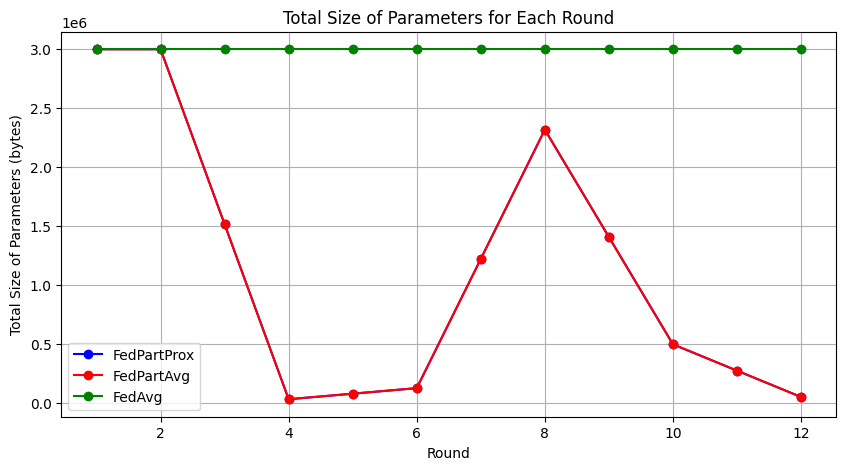

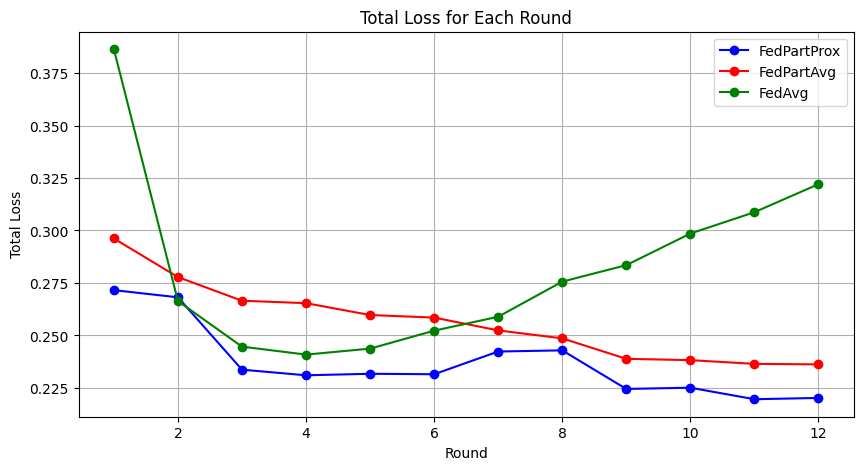

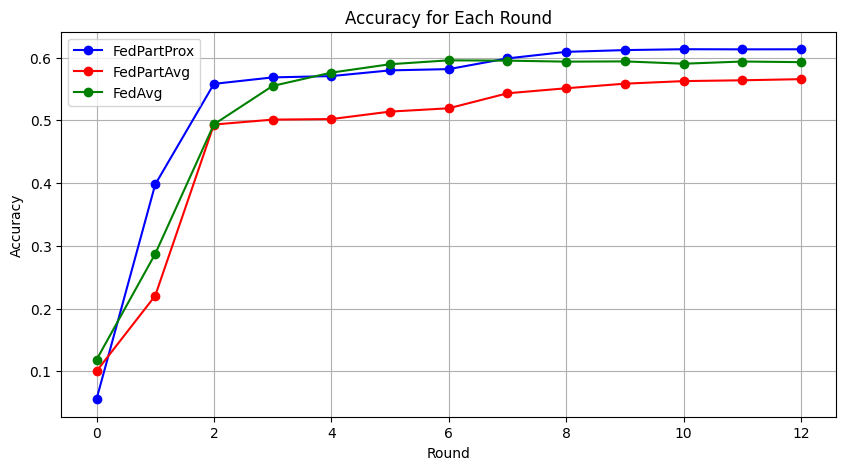

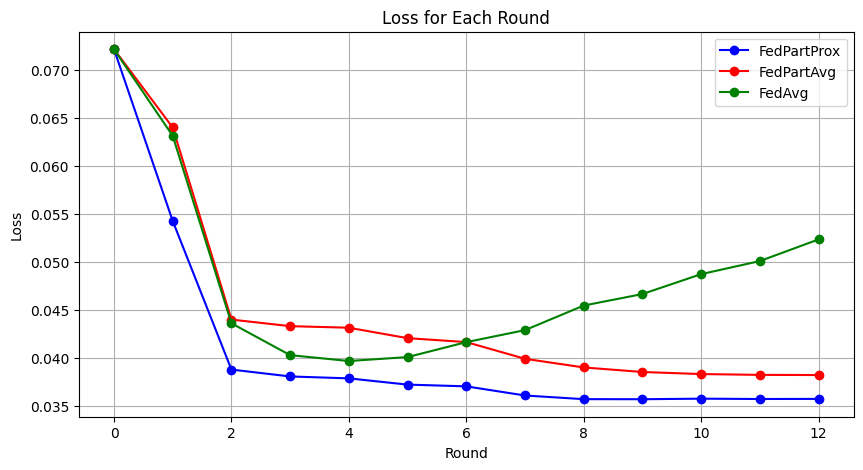

In [51]:
fed_part_prox_rounds = list(fed_part_prox_result.keys())
fed_part_prox_sizes = [fed_part_prox_result[round]["total_size"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_losses = [fed_part_prox_result[round]["total_loss"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_prox_model_rounds = list(fed_part_prox_model_results.keys())
fed_part_prox_accuracies = [fed_part_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_global_losses = [fed_part_prox_model_results[round]["global_loss"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.legend()
plt.grid(True)




# FedPartMoon Experiments:

In [13]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_result = {}
fed_moon_model_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoon(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters
        self.updated_layers = -1


    def __repr__(self) -> str:
        return "FedPartMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        self.layer_training_sequence = self.generate_layer_training_sequence()
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_results:
            expand_fed_moon_result= {**fed_moon_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_results[server_round] = expand_fed_moon_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index],"updated_layers": self.updated_layers}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )

        print(f"sample size {sample_size} and min num clients {min_num_clients}")
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []

        params_array = parameters_to_ndarrays(parameters)
        
        # If doing full model update, send all parameters
        if self.layer_training_sequence[self.training_sequence_index] == -1 or self.updated_layers == -1:
            selected_params = parameters
        else:
            layer_idx = self.updated_layers
            selected_params = ndarrays_to_parameters([
                    params_array[layer_idx * 2],     # Weight
                    params_array[layer_idx * 2 + 1]  # Bias
                ])


        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(selected_params, config)))

        self.updated_layers = self.layer_training_sequence[self.training_sequence_index]
        self.training_sequence_index = self.training_sequence_index + 1

        return fit_configurations

        
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
            total_size += fit_res.metrics["recieved_parameter_size"]
        
        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_result= {"total_size": total_size}

        fed_moon_result[server_round] = expand_fed_moon_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        trained_layer = results[0][1].metrics["trained_layer"]
        print(f"aggregated weight size {len(aggregated_weights)} ")

        if trained_layer == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            print(f"updateing layers {trained_layer* 2}  and {trained_layer* 2 + 1} ")
            current_model[trained_layer* 2] = aggregated_weights[0]
            current_model[trained_layer* 2 +1] = aggregated_weights[1]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_result= {"total_loss": total_loss}

        fed_moon_result[server_round] = expand_fed_moon_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [ ]:
import os

class FedMoonPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader, context: Context):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"
        self.client_state = context.state

        if "net_parameters" not in self.client_state.parameters_records:
            self.client_state.parameters_records["net_parameters"] = ParametersRecord()
            # Save initial model state
            self._save_model_state()



    def _save_model_state(self):
        """Save current model parameters to context"""
        p_record = ParametersRecord()
        parameters = get_parameters(self.net)
        
        for i, param in enumerate(parameters):
            p_record[f"layer_{i}"] = array_from_numpy(param)
        
        self.client_state.parameters_records["net_parameters"] = p_record

    def _load_model_state(self):
        """Load model parameters from context"""
        p_record = self.client_state.parameters_records["net_parameters"]
        parameters = []
        
        for i in range(len(p_record)):
            parameters.append(p_record[f"layer_{i}"].numpy())
        
        set_parameters(self.net, parameters)

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = [parameters[config["trainable_layers"]*2], parameters[config["trainable_layers"]*2 +1]]
        return trained_layer

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # update params for current model (loading global params)
        self._load_model_state()
        recieved_parameter_size = get_parameters_size(ndarrays_to_parameters(parameters))  
        set_parameters(self.net, parameters, config["updated_layers"])

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        

        print(f"trainable layers: {config}")
        freeze_layers(self.net, config["trainable_layers"])
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        self._save_model_state()
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return self.get_parameters(config), len(self.trainloader), {"trained_layer": config["trainable_layers"], "recieved_parameter_size": recieved_parameter_size}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        self._load_model_state()
        current_params = get_parameters(self.net)
        set_parameters(self.net, current_params)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    if not hasattr(context, 'net'):
        context.net = MoonNet().to(DEVICE)
    
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonPartFlowerClient(partition_id=partition_id,
        net=context.net,
        trainloader=trainloader,
        valloader=valloader,
        context=context).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

def get_evaluate_fn_moon(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test_moon(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate


In [15]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoon(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=12, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07216114001274108, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57815) [Client 3] fit, config: {'updated_layers': -1, 'trainable_layers': -1}
(ClientAppActor pid=57815) trainable layers: {'updated_layers': -1, 'trainable_layers': -1}
(ClientAppActor pid=57815) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=57815) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=57815) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=57815) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=57815) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=57815) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=57815) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=57815) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=57815) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=57815) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=57815)

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=57816) Epoch: 7 Loss: 2.370996 Loss1: 1.282282 Loss2: 1.088714 [repeated 12x across cluster]
aggregated weight size 10 


INFO :      fit progress: (1, 0.05605323244333267, {'accuracy': 0.3906}, 46.05979416600894)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57816) [Client 0] evaluate, config: {}
(ClientAppActor pid=57816) [Client 2] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57818) [Client 0] fit, config: {'updated_layers': -1, 'trainable_layers': -1}
(ClientAppActor pid=57818) trainable layers: {'updated_layers': -1, 'trainable_layers': -1}
(ClientAppActor pid=57818) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=57818) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=57818) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=57818) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=57818) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=57818) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=57818) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=57818) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=57818) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=57818) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=57818)

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 10 


INFO :      fit progress: (2, 0.04516542004942894, {'accuracy': 0.5112}, 84.59463037500973)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57818) [Client 4] evaluate, config: {}
(ClientAppActor pid=57817) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=57817) Epoch: 7 Loss: 2.879031 Loss1: 1.028125 Loss2: 1.850906 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57815) [Client 2] fit, config: {'updated_layers': -1, 'trainable_layers': 0}
(ClientAppActor pid=57815) trainable layers: {'updated_layers': -1, 'trainable_layers': 0}
(ClientAppActor pid=57815) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=57815) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=57815) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=57815) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=57815) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=57815) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=57815) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=57815) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=57815) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=57815) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=57815) Started training 

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 2 
updateing layers 0  and 1 


INFO :      fit progress: (3, 0.041940303987264636, {'accuracy': 0.5252}, 122.11050245800288)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57814) [Client 4] evaluate, config: {}
(ClientAppActor pid=57817) Epoch: 7 Loss: 3.220622 Loss1: 1.216080 Loss2: 2.004543 [repeated 11x across cluster]
(ClientAppActor pid=57817) [Client 4] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57815) [Client 1] fit, config: {'updated_layers': 0, 'trainable_layers': 0}
(ClientAppActor pid=57815) trainable layers: {'updated_layers': 0, 'trainable_layers': 0}
(ClientAppActor pid=57815) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=57815) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=57815) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=57815) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=57815) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=57815) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=57815) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=57815) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=57815) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=57815) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=57815) Started training mo

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 2 
updateing layers 0  and 1 


INFO :      fit progress: (4, 0.04138889842629433, {'accuracy': 0.5361}, 166.18886325000494)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57814) [Client 5] evaluate, config: {}
(ClientAppActor pid=57818) Epoch: 7 Loss: 4.705443 Loss1: 1.260250 Loss2: 3.445193 [repeated 6x across cluster]
(ClientAppActor pid=57818) [Client 2] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57813) [Client 3] fit, config: {'updated_layers': 0, 'trainable_layers': 1}
(ClientAppActor pid=57813) trainable layers: {'updated_layers': 0, 'trainable_layers': 1}
(ClientAppActor pid=57813) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=57813) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=57813) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=57813) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=57813) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=57813) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=57813) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=57813) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=57813) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=57813) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=57813) Started training mo

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 2 
updateing layers 2  and 3 


INFO :      fit progress: (5, 0.03980814173221588, {'accuracy': 0.5515}, 202.3624447910115)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57818) [Client 0] evaluate, config: {}
(ClientAppActor pid=57817) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=57817) Epoch: 7 Loss: 4.607510 Loss1: 1.210110 Loss2: 3.397400 [repeated 4x across cluster]
(ClientAppActor pid=57816) 


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57814) [Client 5] fit, config: {'updated_layers': 1, 'trainable_layers': 1}
(ClientAppActor pid=57814) trainable layers: {'updated_layers': 1, 'trainable_layers': 1}
(ClientAppActor pid=57814) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=57814) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=57814) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=57814) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=57814) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=57814) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=57814) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=57814) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=57814) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=57814) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=57814) Started training mo

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 2 
updateing layers 2  and 3 
(ClientAppActor pid=57815) Epoch: 7 Loss: 4.533429 Loss1: 1.152418 Loss2: 3.381011 [repeated 11x across cluster]


INFO :      fit progress: (6, 0.039533213704824446, {'accuracy': 0.5559}, 237.0130059580115)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57816) [Client 1] evaluate, config: {}
(ClientAppActor pid=57815) [Client 4] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57817) [Client 5] fit, config: {'updated_layers': 1, 'trainable_layers': 2}
(ClientAppActor pid=57817) trainable layers: {'updated_layers': 1, 'trainable_layers': 2}
(ClientAppActor pid=57817) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=57817) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=57817) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=57817) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=57817) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=57817) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=57817) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=57817) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=57817) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=57817) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=57817) Started training mo

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=57815) [Client 4] get_parameters [repeated 5x across cluster]
aggregated weight size 2 
updateing layers 4  and 5 


INFO :      fit progress: (7, 0.03796117910146713, {'accuracy': 0.58}, 273.1710604580003)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57815) [Client 1] evaluate, config: {}
(ClientAppActor pid=57815) Epoch: 7 Loss: 4.123061 Loss1: 0.829261 Loss2: 3.293799 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57818) [Client 2] fit, config: {'updated_layers': 2, 'trainable_layers': 2}
(ClientAppActor pid=57818) trainable layers: {'updated_layers': 2, 'trainable_layers': 2}
(ClientAppActor pid=57818) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=57818) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=57818) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=57818) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=57818) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=57818) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=57818) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=57818) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=57818) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=57818) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=57818) Started training mo

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 2 
updateing layers 4  and 5 


INFO :      fit progress: (8, 0.03792848641872406, {'accuracy': 0.5804}, 311.0587012080068)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57816) [Client 0] evaluate, config: {}
(ClientAppActor pid=57816) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=57816) Epoch: 7 Loss: 2.933016 Loss1: 0.903363 Loss2: 2.029653 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57814) [Client 4] fit, config: {'updated_layers': 2, 'trainable_layers': 3}
(ClientAppActor pid=57814) trainable layers: {'updated_layers': 2, 'trainable_layers': 3}
(ClientAppActor pid=57814) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=57814) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=57814) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=57814) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=57814) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=57814) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=57814) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=57814) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=57814) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=57814) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=57814) Started training mo

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 2 
updateing layers 6  and 7 
(ClientAppActor pid=57813) Epoch: 7 Loss: 3.032129 Loss1: 0.988712 Loss2: 2.043417 [repeated 12x across cluster]


INFO :      fit progress: (9, 0.037297754299640655, {'accuracy': 0.5839}, 347.3365129580052)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57813) [Client 4] evaluate, config: {}
(ClientAppActor pid=57813) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=57817) [Client 0] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57814) [Client 0] fit, config: {'updated_layers': 3, 'trainable_layers': 3}
(ClientAppActor pid=57814) trainable layers: {'updated_layers': 3, 'trainable_layers': 3}
(ClientAppActor pid=57814) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=57814) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=57814) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=57814) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=57814) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=57814) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=57814) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=57814) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=57814) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=57814) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=57814) Started training mo

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 2 
updateing layers 6  and 7 


INFO :      fit progress: (10, 0.0371714223742485, {'accuracy': 0.5841}, 389.3989380830026)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57818) [Client 3] evaluate, config: {}
(ClientAppActor pid=57818) Epoch: 7 Loss: 2.638727 Loss1: 0.991594 Loss2: 1.647133 [repeated 11x across cluster]
(ClientAppActor pid=57818) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=57818) 


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57816) [Client 0] fit, config: {'updated_layers': 3, 'trainable_layers': 4}
(ClientAppActor pid=57816) trainable layers: {'updated_layers': 3, 'trainable_layers': 4}
(ClientAppActor pid=57816) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=57816) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=57816) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=57816) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=57816) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=57816) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=57816) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=57816) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=57816) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=57816) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=57816) Started training mo

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 2 
updateing layers 8  and 9 


INFO :      fit progress: (11, 0.03705464987754822, {'accuracy': 0.5882}, 424.16864995801006)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57814) [Client 3] evaluate, config: {}
(ClientAppActor pid=57814) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=57814) Epoch: 7 Loss: 3.397274 Loss1: 0.988803 Loss2: 2.408471 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


sample size 6 and min num clients 2
(ClientAppActor pid=57817) [Client 4] fit, config: {'updated_layers': 4, 'trainable_layers': 4}
(ClientAppActor pid=57817) trainable layers: {'updated_layers': 4, 'trainable_layers': 4}
(ClientAppActor pid=57817) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=57817) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=57817) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=57817) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=57817) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=57817) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=57817) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=57817) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=57817) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=57817) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=57817) Started training mo

INFO :      aggregate_fit: received 6 results and 0 failures


aggregated weight size 2 
updateing layers 8  and 9 


INFO :      fit progress: (12, 0.037103560674190524, {'accuracy': 0.588}, 455.4776035410032)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=57818) [Client 3] evaluate, config: {}
(ClientAppActor pid=57815) Epoch: 7 Loss: 4.458140 Loss1: 0.992403 Loss2: 3.465736 [repeated 11x across cluster]
(ClientAppActor pid=57815) [Client 2] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 12 round(s) in 459.72s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05724500078269182
INFO :      		round 2: 0.04515012071822327
INFO :      		round 3: 0.04217818040096076
INFO :      		round 4: 0.04166055076946094
INFO :      		round 5: 0.040215805885798206
INFO :      		round 6: 0.04001748567296967
INFO :      		round 7: 0.03813815233609577
INFO :      		round 8: 0.03809176262865136
INFO :      		round 9: 0.03759914263561472
INFO :      		round 10: 0.03737694434143739
INFO :      		round 11: 0.03721895410052253
INFO :      		round 12: 0.03724998125493217
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07216114001274108
INFO :      		round 1: 0.05605323244333267
INFO :      		round 2: 0.04516542004942894
INFO :      		round 3: 0.041940303987264636
INFO :      		round 4: 0.04138889842629433
INFO :      		round 5: 0.039808

(ClientAppActor pid=57817) [Client 1] evaluate, config: {} [repeated 5x across cluster]


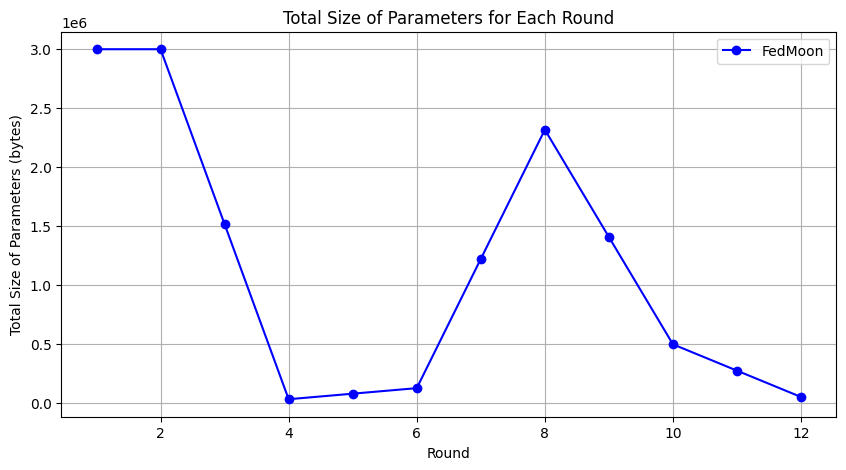

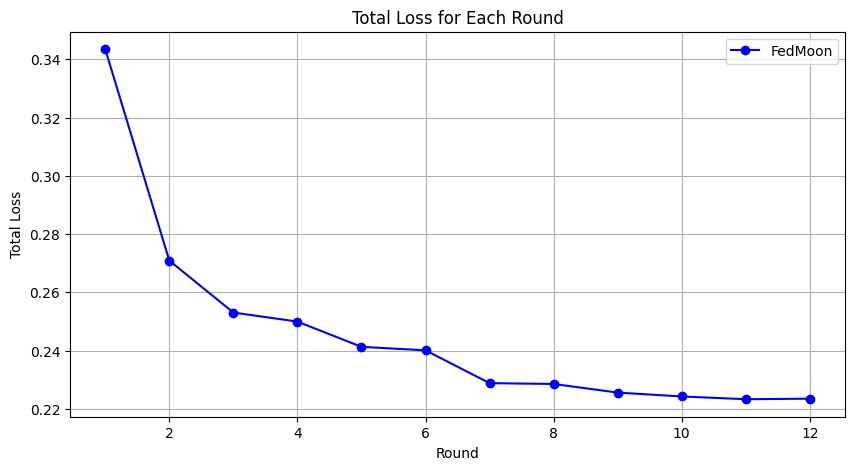

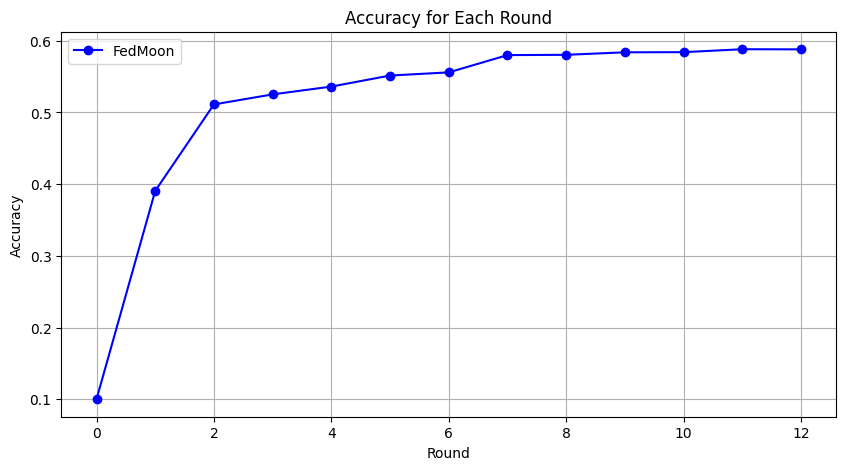

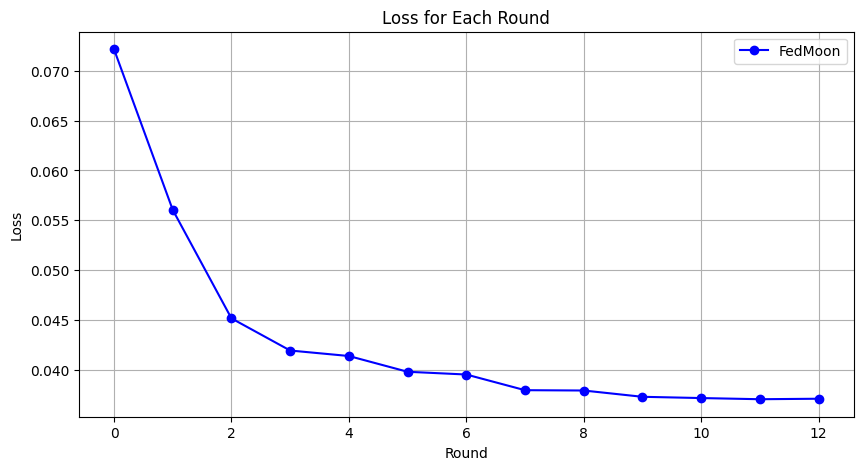

In [16]:
fed_part_moon_rounds = list(fed_moon_result.keys())
fed_part_moon_sizes = [fed_moon_result[round]["total_size"] for round in fed_part_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_moon_rounds, fed_part_moon_sizes, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_moon_losses = [fed_moon_result[round]["total_loss"] for round in fed_part_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_moon_rounds, fed_part_moon_losses, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)

fed_part_moon_model_rounds = list(fed_moon_model_results.keys())
fed_part_moon_accuracies = [fed_moon_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_moon_model_rounds, fed_part_moon_accuracies, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_moon_global_losses = [fed_moon_model_results[round]["global_loss"] for round in fed_part_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_moon_model_rounds, fed_part_moon_global_losses, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.legend()
plt.grid(True)


# FedMoon experiments:

In [ ]:
class FedMoonNoFreezeFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        trainable_layer = config["trainable_layers"]
        self._save_model_state()
        
        if trainable_layer == -1:
            return parameters
        
        trained_layer = [parameters[trainable_layer*2], parameters[trainable_layer*2 +1]]
        return trained_layer

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return get_parameters(self.net), len(self.trainloader), {}


    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonNoFreezeFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)


In [42]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_no_freeze_result = {}
fed_moon_model_no_freeze_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoonNoFreeze(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_no_freeze_results:
            expand_fed_moon_no_freeze_result= {**fed_moon_model_no_freeze_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_no_freeze_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_no_freeze_results[server_round] = expand_fed_moon_no_freeze_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters) * 2
        
        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_no_freeze_result= {"total_size": total_size}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        self.latest_parameters = ndarrays_to_parameters(aggregated_weights)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_no_freeze_result= {"total_loss": total_loss}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [43]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoonNoFreeze(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=12, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07214766519069672, {'accuracy': 0.1002}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=13240) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=13240)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=13240) [Client 0] fit, config: {}
(ClientAppActor pid=13240) Started training moon
(ClientAppActor pid=13240) Epoch: 0 Loss: 3.366177 Loss1: 2.181330 Loss2: 1.184847
(ClientAppActor pid=13236) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13236) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13240) Epoch: 2 Loss: 2.815715 Loss1: 1.616325 Loss2: 1.199390 [repeated 12x across cluster]
(ClientAppActor pid=13240) Epoch: 4 Loss: 2.632801 Loss1: 1.435335 Loss2: 1.197466 [repeated 12x across cluster]
(ClientAppActor pid=13240) Epoch: 6 Loss: 2.522071 Loss1: 1.323522 Loss2: 1.198549 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (1, 0.055424556362628934, {'accuracy': 0.3543}, 38.56259275000775)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13239) [Client 2] evaluate, config: {}
(ClientAppActor pid=13237) Epoch: 7 Loss: 2.335783 Loss1: 1.328520 Loss2: 1.007263 [repeated 11x across cluster]


(ClientAppActor pid=13239) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=13239)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13236) [Client 5] fit, config: {}
(ClientAppActor pid=13236) Started training moon
(ClientAppActor pid=13237) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13236) Epoch: 0 Loss: 3.863373 Loss1: 1.505388 Loss2: 2.357985
(ClientAppActor pid=13238) Epoch: 0 Loss: 3.562848 Loss1: 1.497498 Loss2: 2.065350
(ClientAppActor pid=13237) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13237) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13236) Epoch: 2 Loss: 3.529023 Loss1: 1.303620 Loss2: 2.225402 [repeated 11x across cluster]
(ClientAppActor pid=13236) Epoch: 4 Loss: 3.383807 Loss1: 1.166310 Loss2: 2.217498 [repeated 12x across cluster]
(ClientAppActor pid=13236) Epoch: 6 Loss: 3.265599 Loss1: 1.049285 Loss2: 2.216315 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (2, 0.043291253250837325, {'accuracy': 0.5212}, 75.24548849998973)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13239) [Client 2] evaluate, config: {}
(ClientAppActor pid=13237) Epoch: 7 Loss: 2.989675 Loss1: 0.984449 Loss2: 2.005226 [repeated 11x across cluster]


(ClientAppActor pid=13239) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13239)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13235) [Client 1] fit, config: {}
(ClientAppActor pid=13235) Started training moon
(ClientAppActor pid=13240) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13235) Epoch: 0 Loss: 2.536564 Loss1: 1.250118 Loss2: 1.286446
(ClientAppActor pid=13240) Epoch: 0 Loss: 2.547509 Loss1: 1.251279 Loss2: 1.296230
(ClientAppActor pid=13239) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13239) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13235) Epoch: 2 Loss: 2.303598 Loss1: 1.070549 Loss2: 1.233049 [repeated 11x across cluster]
(ClientAppActor pid=13235) Epoch: 4 Loss: 2.164446 Loss1: 0.928016 Loss2: 1.236430 [repeated 12x across cluster]
(ClientAppActor pid=13235) Epoch: 6 Loss: 2.023519 Loss1: 0.781057 Loss2: 1.242462 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (3, 0.04056145700216293, {'accuracy': 0.5746}, 112.64204779203283)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=13236) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13236)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=13236) [Client 0] evaluate, config: {}
(ClientAppActor pid=13236) Epoch: 7 Loss: 1.993749 Loss1: 0.680760 Loss2: 1.312989 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13239) [Client 2] fit, config: {}
(ClientAppActor pid=13239) Started training moon
(ClientAppActor pid=13235) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13239) Epoch: 0 Loss: 2.690119 Loss1: 1.160831 Loss2: 1.529288
(ClientAppActor pid=13235) Epoch: 0 Loss: 2.773072 Loss1: 1.162845 Loss2: 1.610227
(ClientAppActor pid=13237) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13237) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13239) Epoch: 2 Loss: 2.361719 Loss1: 0.916299 Loss2: 1.445420 [repeated 11x across cluster]
(ClientAppActor pid=13239) Epoch: 4 Loss: 2.196340 Loss1: 0.750657 Loss2: 1.445683 [repeated 12x across cluster]
(ClientAppActor pid=13239) Epoch: 6 Loss: 2.050725 Loss1: 0.601174 Loss2: 1.449551 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (4, 0.043816600000858304, {'accuracy': 0.5871}, 148.9586116670398)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13236) [Client 1] evaluate, config: {}
(ClientAppActor pid=13238) Epoch: 7 Loss: 1.952717 Loss1: 0.498347 Loss2: 1.454370 [repeated 11x across cluster]


(ClientAppActor pid=13236) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13236)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13235) [Client 4] fit, config: {}
(ClientAppActor pid=13235) Started training moon
(ClientAppActor pid=13237) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13235) Epoch: 0 Loss: 2.431128 Loss1: 1.027486 Loss2: 1.403642
(ClientAppActor pid=13239) Epoch: 0 Loss: 2.372904 Loss1: 1.081566 Loss2: 1.291338
(ClientAppActor pid=13237) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13237) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13237) Epoch: 1 Loss: 2.175809 Loss1: 0.872674 Loss2: 1.303134 [repeated 10x across cluster]
(ClientAppActor pid=13239) Epoch: 3 Loss: 1.951337 Loss1: 0.692153 Loss2: 1.259185 [repeated 7x across cluster]
(ClientAppActor pid=13239) Epoch: 5 Loss: 1.784568 Loss1: 0.516338 Loss2: 1.268230 [repeated 12x across cluster]
(ClientAppActor pid=13239) Epoch: 7 Loss: 1.664546 Loss1: 0.387939 Loss2: 1.276607 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (5, 0.046543850952386855, {'accuracy': 0.5879}, 186.29476445901673)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13239) [Client 5] evaluate, config: {}
(ClientAppActor pid=13237) Epoch: 7 Loss: 1.688677 Loss1: 0.361293 Loss2: 1.327384 [repeated 5x across cluster]


(ClientAppActor pid=13239) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13239)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13235) [Client 2] fit, config: {}
(ClientAppActor pid=13235) Started training moon
(ClientAppActor pid=13236) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13235) Epoch: 0 Loss: 2.752061 Loss1: 1.022776 Loss2: 1.729285
(ClientAppActor pid=13238) Epoch: 0 Loss: 2.555640 Loss1: 0.992335 Loss2: 1.563305
(ClientAppActor pid=13240) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13240) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13235) Epoch: 2 Loss: 2.328892 Loss1: 0.678320 Loss2: 1.650571 [repeated 11x across cluster]
(ClientAppActor pid=13235) Epoch: 4 Loss: 2.164077 Loss1: 0.504951 Loss2: 1.659126 [repeated 12x across cluster]
(ClientAppActor pid=13235) Epoch: 6 Loss: 2.036515 Loss1: 0.367756 Loss2: 1.668759 [repeated 12x across cluster]
(ClientAppActor pid=13236) Epoch: 7 Loss: 1.881664 Loss1: 0.326266 Loss2: 1.555398 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (6, 0.051153808546066284, {'accuracy': 0.579}, 224.49774079199415)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13237) [Client 1] evaluate, config: {}


(ClientAppActor pid=13237) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=13240) Epoch: 7 Loss: 1.808487 Loss1: 0.282009 Loss2: 1.526478 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13237) [Client 4] fit, config: {}
(ClientAppActor pid=13237) Started training moon
(ClientAppActor pid=13240) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13237) Epoch: 0 Loss: 2.460163 Loss1: 0.939256 Loss2: 1.520907
(ClientAppActor pid=13239) Epoch: 0 Loss: 2.320067 Loss1: 0.990414 Loss2: 1.329654
(ClientAppActor pid=13238) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13238) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13239) Epoch: 2 Loss: 1.891967 Loss1: 0.580163 Loss2: 1.311804 [repeated 11x across cluster]
(ClientAppActor pid=13239) Epoch: 4 Loss: 1.739875 Loss1: 0.413330 Loss2: 1.326545 [repeated 12x across cluster]
(ClientAppActor pid=13238) Epoch: 5 Loss: 1.817102 Loss1: 0.333967 Loss2: 1.483136 [repeated 11x across cluster]
(ClientAppActor pid=13239) Epoch: 7 Loss: 1.577102 Loss1: 0.242895 Loss2: 1.334206 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (7, 0.054809888875484464, {'accuracy': 0.5801}, 262.05623708403436)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13235) [Client 3] evaluate, config: {}
(ClientAppActor pid=13238) Epoch: 7 Loss: 1.712564 Loss1: 0.223910 Loss2: 1.488654 [repeated 5x across cluster]


(ClientAppActor pid=13237) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13237)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13235) [Client 3] fit, config: {}
(ClientAppActor pid=13235) Started training moon
(ClientAppActor pid=13236) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13237) Epoch: 0 Loss: 2.720006 Loss1: 0.939441 Loss2: 1.780565
(ClientAppActor pid=13235) Epoch: 0 Loss: 2.826515 Loss1: 0.962234 Loss2: 1.864282
(ClientAppActor pid=13239) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13240) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13237) Epoch: 2 Loss: 2.250374 Loss1: 0.524847 Loss2: 1.725527 [repeated 11x across cluster]
(ClientAppActor pid=13237) Epoch: 4 Loss: 2.079064 Loss1: 0.352180 Loss2: 1.726884 [repeated 12x across cluster]
(ClientAppActor pid=13239) Epoch: 6 Loss: 2.076251 Loss1: 0.282829 Loss2: 1.793422 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (8, 0.05736462283730507, {'accuracy': 0.5725}, 299.0475792500074)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13236) [Client 0] evaluate, config: {}
(ClientAppActor pid=13236) Epoch: 7 Loss: 1.957351 Loss1: 0.239361 Loss2: 1.717990 [repeated 11x across cluster]


(ClientAppActor pid=13236) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13236)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13239) [Client 3] fit, config: {}
(ClientAppActor pid=13239) Started training moon
(ClientAppActor pid=13235) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13239) Epoch: 0 Loss: 2.752407 Loss1: 0.973955 Loss2: 1.778452
(ClientAppActor pid=13238) Epoch: 0 Loss: 2.528790 Loss1: 0.906893 Loss2: 1.621897
(ClientAppActor pid=13237) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13237) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13239) Epoch: 2 Loss: 2.280811 Loss1: 0.529163 Loss2: 1.751647 [repeated 11x across cluster]
(ClientAppActor pid=13239) Epoch: 4 Loss: 2.120607 Loss1: 0.359225 Loss2: 1.761382 [repeated 12x across cluster]
(ClientAppActor pid=13239) Epoch: 6 Loss: 2.006185 Loss1: 0.245193 Loss2: 1.760992 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (9, 0.060738653630018236, {'accuracy': 0.5634}, 336.01905120903393)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13238) [Client 2] evaluate, config: {}
(ClientAppActor pid=13236) Epoch: 7 Loss: 1.927100 Loss1: 0.223933 Loss2: 1.703167 [repeated 11x across cluster]


(ClientAppActor pid=13238) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13238)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13238) [Client 5] fit, config: {}
(ClientAppActor pid=13238) Started training moon
(ClientAppActor pid=13239) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13238) Epoch: 0 Loss: 2.966814 Loss1: 0.943981 Loss2: 2.022833
(ClientAppActor pid=13236) Epoch: 0 Loss: 2.898963 Loss1: 0.972642 Loss2: 1.926321
(ClientAppActor pid=13237) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13237) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13238) Epoch: 2 Loss: 2.440498 Loss1: 0.483481 Loss2: 1.957018 [repeated 11x across cluster]
(ClientAppActor pid=13239) Epoch: 4 Loss: 2.298770 Loss1: 0.337225 Loss2: 1.961545 [repeated 12x across cluster]
(ClientAppActor pid=13239) Epoch: 6 Loss: 2.189299 Loss1: 0.236124 Loss2: 1.953175 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (10, 0.06187721636891365, {'accuracy': 0.5544}, 373.39426720899064)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=13235) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13235)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=13236) [Client 1] evaluate, config: {}
(ClientAppActor pid=13237) Epoch: 7 Loss: 2.091448 Loss1: 0.206112 Loss2: 1.885336 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13238) [Client 3] fit, config: {}
(ClientAppActor pid=13238) Started training moon
(ClientAppActor pid=13240) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=13238) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=13238)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=13238) Epoch: 0 Loss: 2.817211 Loss1: 0.950863 Loss2: 1.866348
(ClientAppActor pid=13239) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13239) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13238) Epoch: 2 Loss: 2.307581 Loss1: 0.486651 Loss2: 1.820929 [repeated 12x across cluster]
(ClientAppActor pid=13235) Epoch: 4 Loss: 2.048033 Loss1: 0.282940 Loss2: 1.765093 [repeated 12x across cluster]
(ClientAppActor pid=13235) Epoch: 6 Loss: 1.991722 Loss1: 0.226139 Loss2: 1.765583 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (11, 0.06369662203192711, {'accuracy': 0.5476}, 411.9818916670047)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13235) [Client 5] evaluate, config: {}
(ClientAppActor pid=13240) Epoch: 7 Loss: 2.069468 Loss1: 0.218822 Loss2: 1.850646 [repeated 11x across cluster]


(ClientAppActor pid=13235) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=13235)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13239) [Client 2] fit, config: {}
(ClientAppActor pid=13239) Started training moon
(ClientAppActor pid=13236) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13239) Epoch: 0 Loss: 2.928905 Loss1: 0.962870 Loss2: 1.966035
(ClientAppActor pid=13237) Epoch: 0 Loss: 3.002268 Loss1: 0.957163 Loss2: 2.045105
(ClientAppActor pid=13240) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13240) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=13239) Epoch: 2 Loss: 2.385028 Loss1: 0.484248 Loss2: 1.900780 [repeated 11x across cluster]
(ClientAppActor pid=13239) Epoch: 4 Loss: 2.204661 Loss1: 0.313562 Loss2: 1.891100 [repeated 12x across cluster]
(ClientAppActor pid=13238) Epoch: 5 Loss: 2.289188 Loss1: 0.237913 Loss2: 2.051275 [repeated 10x across cluster]
(ClientAppActor pid=13235) Epoch: 7 Loss: 2.091276 Loss1: 0.203323 Loss2: 1.887953 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (12, 0.06427845162153244, {'accuracy': 0.5485}, 450.0146302090143)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=13239) [Client 3] evaluate, config: {}
(ClientAppActor pid=13240) Epoch: 7 Loss: 2.066100 Loss1: 0.219891 Loss2: 1.846209 [repeated 5x across cluster]


(ClientAppActor pid=13239) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=13239)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 12 round(s) in 453.11s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05692493605675685
INFO :      		round 2: 0.04486543147224494
INFO :      		round 3: 0.04224335529331778
INFO :      		round 4: 0.04524164641165383
INFO :      		round 5: 0.04759486816626826
INFO :      		round 6: 0.05238275675237524
INFO :      		round 7: 0.055668539643418766
INFO :      		round 8: 0.05845334443884405
INFO :      		round 9: 0.06116343375278267
INFO :      		round 10: 0.06306143843383938
INFO :      		round 11: 0.0651

(ClientAppActor pid=13240) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=13240) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=13240)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


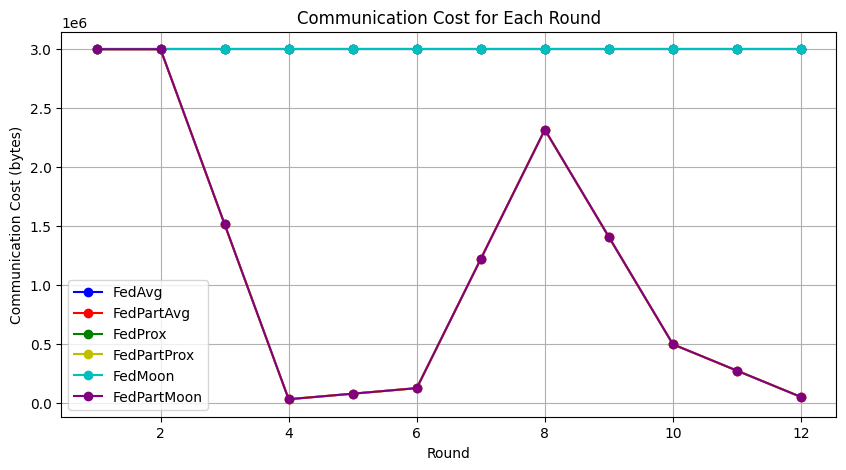

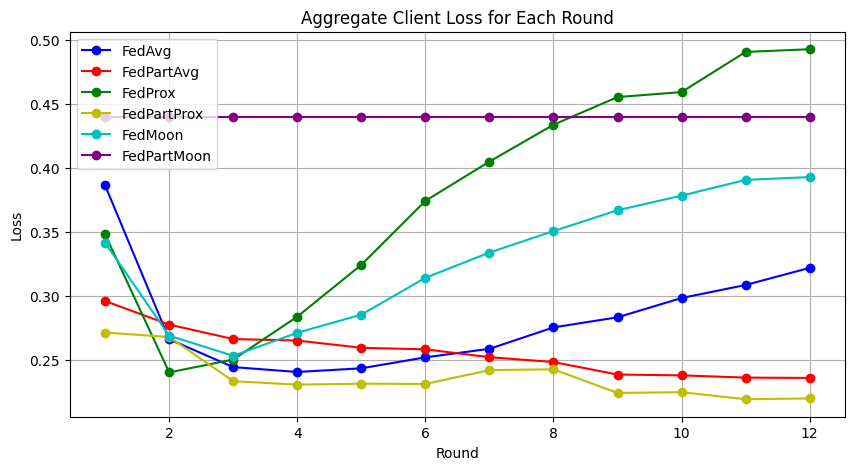

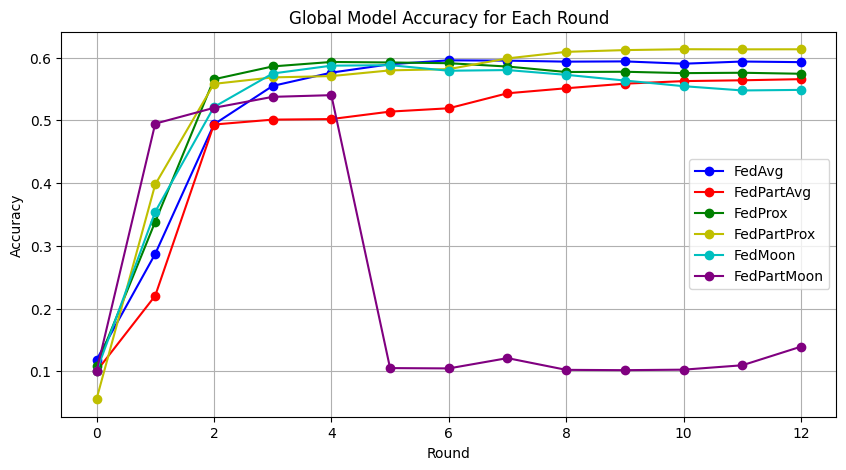

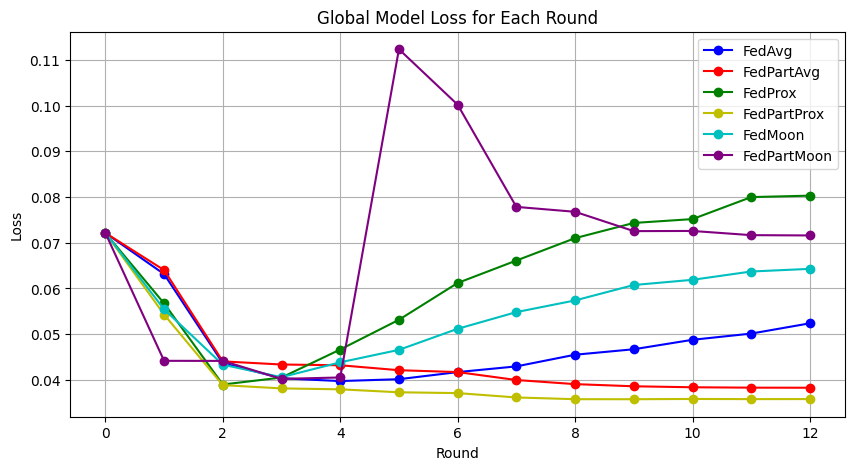

In [52]:
fed_moon_rounds = list(fed_moon_no_freeze_result.keys())
fed_moon_sizes = [fed_moon_no_freeze_result[round]["total_size"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_rounds, fed_part_moon_sizes, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Communication Cost (bytes)')
plt.title('Communication Cost for Each Round')
plt.legend()
plt.grid(True)

fed_moon_losses = [fed_moon_no_freeze_result[round]["total_loss"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_rounds, fed_part_moon_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Aggregate Client Loss for Each Round')
plt.legend()
plt.grid(True)

fed_moon_model_rounds = list(fed_moon_model_no_freeze_results.keys())
fed_moon_accuracies = [fed_moon_model_no_freeze_results[round]["global_metrics"]["accuracy"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_model_rounds, fed_prox_accuracies, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_model_rounds, fed_part_moon_accuracies, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Global Model Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_moon_global_losses = [fed_moon_model_no_freeze_results[round]["global_loss"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_model_rounds, fed_prox_global_losses, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_model_rounds, fed_part_moon_global_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Global Model Loss for Each Round')
plt.legend()
plt.grid(True)
